# Air Quality Prediction Based on Environmental Factors

In [ ]:
# Import required modules

import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load Datasets

In this section, I define a function called `Get_Dataset` that retrieves data from the API. The function takes a `dataset_id` as a parameter and returns the dataset in the form of a pandas dataframe. The function performs the following steps:
- Constructs the API URL based on the `dataset_id`.
- Sends a GET request to the API with the specified parameters.
- If the response status code is 200 (indicating a successful request), the CSV data is read using `StringIO` and converted to a pandas dataframe.
- If the response status code is not 200, an error message is printed.

In [ ]:
"""
Get unlimited data from the API v2.1

Parameters:
dataset_id (string): dataset if as from city of Melbourne (https://data.melbourne.vic.gov.au/)

Returns:
Pandas Dataframe: Returns the dataset in shape of pandas dataframe
"""
def Get_Dataset(dataset_id): # pass in dataset id
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets'

    format = 'csv'

    url = f'{base_url}/{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC'
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        return (print(f'Request failed with status code {response.status_code}'))

### Microclimate Dataset

In [ ]:
# Get the first dataset
microclimate_sensors_df = Get_Dataset('microclimate-sensors-data')
microclimate_sensors_df.head()

device_id                received_at  \
0  ICTMicroclimate-09  2024-07-17T15:33:32+00:00   
1  ICTMicroclimate-03  2024-07-17T15:06:13+00:00   
2  ICTMicroclimate-07  2024-07-17T15:21:33+00:00   
3  ICTMicroclimate-08  2024-07-17T15:40:34+00:00   
4  ICTMicroclimate-02  2024-07-17T15:42:47+00:00   

                                      sensorlocation  \
0  SkyFarm (Jeff's Shed). Rooftop - Melbourne Con...   
1                                        CH1 rooftop   
2  Tram Stop 7C - Melbourne Tennis Centre Precinc...   
3  Swanston St - Tram Stop 13 adjacent Federation...   
4                         101 Collins St L11 Rooftop   

                    latlong  minimumwinddirection  averagewinddirection  \
0  -37.8223306, 144.9521696                   0.0                 300.0   
1    -37.8140348, 144.96728                   0.0                 308.0   
2  -37.8222341, 144.9829409                   0.0                 262.0   
3  -37.8184515, 144.9678474                   0.0                 339.0   
4   -37.814604, 144.9702991                   7.0                 118.0   

   maximumwinddirection  minimumwindspeed  averagewindspeed  gustwindspeed  \
0                 359.0               0.0               0.9            3.5   
1                 349.0               0.0               0.4            1.0   
2                 354.0               0.0               0.4            1.6   
3                 359.0               0.0               0.9            4.3   
4                 261.0               1.4               2.1            4.1   

   airtemperature  relativehumidity  atmosphericpressure  pm25  pm10  noise  
0             8.7              86.3               1013.1   1.0   4.0   63.1  
1             8.5              99.0               1008.7   3.0   5.0   69.7  
2             9.0              85.0               1016.1   0.0   0.0   55.3  
3             9.0              83.9               1014.1   1.0   1.0   60.6  
4             9.0              96.7               1009.4   8.0  11.0   69.0

### Argyle Square Air Quality Dataset

In [ ]:
# Get the second dataset
argyle_air_quality_df = Get_Dataset('argyle-square-air-quality')
argyle_air_quality_df.head()

time    dev_id           sensor_name  \
0  2020-06-09T09:02:38+00:00  ems-ec8a  Air Quality Sensor 2   
1  2020-06-09T11:17:37+00:00  ems-ec8a  Air Quality Sensor 2   
2  2022-05-03T21:46:34+00:00  ems-ec8a  Air Quality Sensor 2   
3  2020-06-09T11:32:37+00:00  ems-ec8a  Air Quality Sensor 2   
4  2021-05-15T06:04:33+00:00  ems-ec8a  Air Quality Sensor 2   

                  lat_long  averagespl  carbonmonoxide  humidity  ibatt  \
0  -37.802772, 144.9655513        56.0         -6448.0      65.0   71.0   
1  -37.802772, 144.9655513        55.0         -6916.0      68.0   89.0   
2  -37.802772, 144.9655513        58.0         -6261.0      77.0  169.0   
3  -37.802772, 144.9655513        55.0         -6916.0      69.0   76.0   
4  -37.802772, 144.9655513        56.0         -6261.0      51.0   12.0   

   nitrogendioxide  ozone  particulateserr  particulatesvsn  peakspl   pm1  \
0            287.0  137.0              0.0            151.0     69.0  12.0   
1            325.0  156.0              0.0            151.0     62.0  15.0   
2            268.0  137.0              0.0            151.0     64.0   0.0   
3            325.0  156.0              0.0            151.0     68.0  19.0   
4            258.0  119.0              0.0            151.0     62.0   0.0   

   pm10  pm25  temperature  vbatt  vpanel  
0  19.0  17.0         12.3   3.96    0.00  
1  24.0  22.0         10.9   3.93    0.00  
2   0.0   0.0         15.1   3.76   16.33  
3  29.0  24.0         10.5   3.92    0.00  
4   0.0   0.0         14.9   4.01   18.33

## Data Cleaning and Preprocessing

### Microclimate

In this section, I perform data cleaning and preprocessing on the microclimate dataset. I check for missing values, fill them with appropriate values, and perform additional data transformations. I also extract latitude and longitude information from the 'latlong' column. Finally, I use the KNNImputer to fill missing latitude and longitude values with the nearest available values.

In [ ]:
print(microclimate_sensors_df.info())
print("\n\nMissing values:")
print(microclimate_sensors_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87128 entries, 0 to 87127
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   device_id             87128 non-null  object 
 1   received_at           87128 non-null  object 
 2   sensorlocation        82756 non-null  object 
 3   latlong               82756 non-null  object 
 4   minimumwinddirection  76266 non-null  float64
 5   averagewinddirection  86940 non-null  float64
 6   maximumwinddirection  76266 non-null  float64
 7   minimumwindspeed      76266 non-null  float64
 8   averagewindspeed      86940 non-null  float64
 9   gustwindspeed         76266 non-null  float64
 10  airtemperature        86940 non-null  float64
 11  relativehumidity      86940 non-null  float64
 12  atmosphericpressure   86940 non-null  float64
 13  pm25                  79986 non-null  float64
 14  pm10                  79986 non-null  float64
 15  noise              

In [ ]:
microclimate_sensors_df.fillna({
    'sensorlocation': 'Unknown',
    'minimumwinddirection': microclimate_sensors_df['minimumwinddirection'].median(),
    'averagewinddirection': microclimate_sensors_df['averagewinddirection'].median(),
    'maximumwinddirection': microclimate_sensors_df['maximumwinddirection'].median(),
    'minimumwindspeed': microclimate_sensors_df['minimumwindspeed'].median(),
    'averagewindspeed': microclimate_sensors_df['averagewindspeed'].median(),
    'gustwindspeed': microclimate_sensors_df['gustwindspeed'].median(),
    'airtemperature': microclimate_sensors_df['airtemperature'].median(),
    'relativehumidity': microclimate_sensors_df['relativehumidity'].median(),
    'atmosphericpressure': microclimate_sensors_df['atmosphericpressure'].median(),
    'pm25': microclimate_sensors_df['pm25'].median(),
    'pm10': microclimate_sensors_df['pm10'].median(),
    'noise': microclimate_sensors_df['noise'].median()
}, inplace=True)

# Extracting Lat & Long
microclimate_sensors_df[['lat', 'long']] = microclimate_sensors_df['latlong'].str.split(',', expand=True).astype(float)

# Using KNNImputer to fill missing Latitude and Longitude values with the nearest available values
microclimate_sensors_df[['lat', 'long']] = KNNImputer(n_neighbors=5).fit_transform(microclimate_sensors_df[['lat', 'long']])


# Converting the 'Time' column to datetime
microclimate_sensors_df['received_at'] = pd.to_datetime(microclimate_sensors_df['received_at'])

# Displaying the first few rows of the processed microclimate_sensors_df
print(microclimate_sensors_df.info())
print("\n\nMissing values:")
print(microclimate_sensors_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87128 entries, 0 to 87127
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   device_id             87128 non-null  object             
 1   received_at           87128 non-null  datetime64[ns, UTC]
 2   sensorlocation        87128 non-null  object             
 3   latlong               82756 non-null  object             
 4   minimumwinddirection  87128 non-null  float64            
 5   averagewinddirection  87128 non-null  float64            
 6   maximumwinddirection  87128 non-null  float64            
 7   minimumwindspeed      87128 non-null  float64            
 8   averagewindspeed      87128 non-null  float64            
 9   gustwindspeed         87128 non-null  float64            
 10  airtemperature        87128 non-null  float64            
 11  relativehumidity      87128 non-null  float64            
 12  atmo

### Argyle Square Air Quality

In this section, I perform data cleaning and preprocessing on the Argyle Square air quality dataset. I check for missing values and remove rows where all  columns have missing values. I also extract latitude and longitude information from the 'lat_long' column and drop the original column.

In [ ]:
print(argyle_air_quality_df.info())
print("\n\nMissing values:")
print(argyle_air_quality_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142507 entries, 0 to 142506
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             142507 non-null  object 
 1   dev_id           142507 non-null  object 
 2   sensor_name      142507 non-null  object 
 3   lat_long         142507 non-null  object 
 4   averagespl       132660 non-null  float64
 5   carbonmonoxide   132660 non-null  float64
 6   humidity         132660 non-null  float64
 7   ibatt            132660 non-null  float64
 8   nitrogendioxide  132660 non-null  float64
 9   ozone            132660 non-null  float64
 10  particulateserr  132660 non-null  float64
 11  particulatesvsn  132660 non-null  float64
 12  peakspl          132660 non-null  float64
 13  pm1              132660 non-null  float64
 14  pm10             132660 non-null  float64
 15  pm25             132660 non-null  float64
 16  temperature      132660 non-null  floa

In [ ]:
argyle_air_quality_df.dropna(inplace=True)

# Converting the 'Time' column to datetime
argyle_air_quality_df['time'] = pd.to_datetime(argyle_air_quality_df['time'])

print(microclimate_sensors_df.info())
print("\n\nMissing values:")
print(argyle_air_quality_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87128 entries, 0 to 87127
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   device_id             87128 non-null  object             
 1   received_at           87128 non-null  datetime64[ns, UTC]
 2   sensorlocation        87128 non-null  object             
 3   latlong               82756 non-null  object             
 4   minimumwinddirection  87128 non-null  float64            
 5   averagewinddirection  87128 non-null  float64            
 6   maximumwinddirection  87128 non-null  float64            
 7   minimumwindspeed      87128 non-null  float64            
 8   averagewindspeed      87128 non-null  float64            
 9   gustwindspeed         87128 non-null  float64            
 10  airtemperature        87128 non-null  float64            
 11  relativehumidity      87128 non-null  float64            
 12  atmo

## Exploratory Data Analysis (EDA)

In this section, I conduct exploratory data analysis on the microclimate dataset.

- **Histogram:** I visualize the distribution of key variables using histograms. The plots provide insights into the data distribution and help identify any anomalies or patterns.

- **Pair Plots:** I create a pairplot of all numerical variables in the microclimate dataset. The pairplot shows the relationships between variables and includes regression lines for each scatter plot. This plot helps us understand the correlations and dependencies between different variables.

### Microclimate

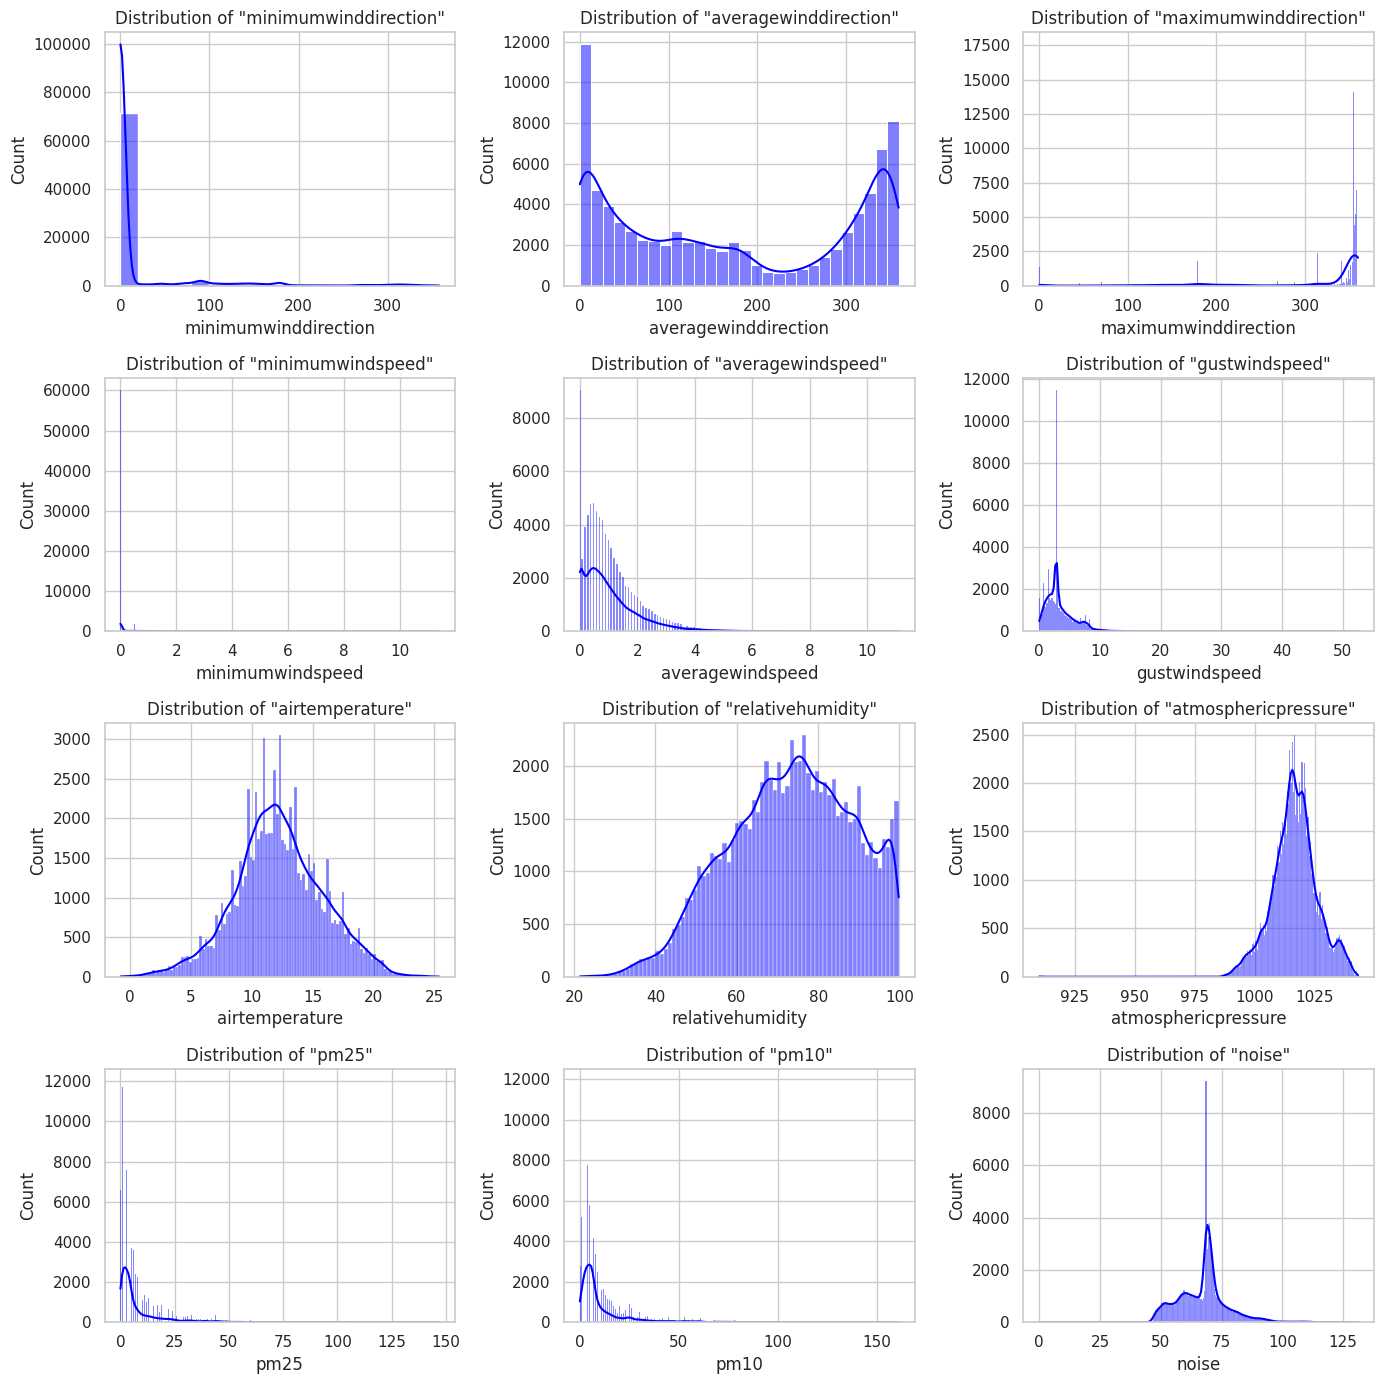

In [ ]:
# Setting the aesthetics for the plots
sns.set_theme(style="whitegrid")

# Selecting only the numerical columns for the pairplot
microclimate_float_columns = [col for col in microclimate_sensors_df.select_dtypes(include=['float64']).columns if col not in ['lat', 'long']]

# Plotting the distribution of key variables
fig, axes = plt.subplots(4, 3, figsize=(14, 14))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, col_name in enumerate(microclimate_float_columns):
    sns.histplot(microclimate_sensors_df[col_name], kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of "{col_name}"')
    axes[i].set_xlabel(col_name)  # Add x-axis label
    axes[i].set_ylabel('Count')  # Add y-axis label

plt.tight_layout()
plt.show()


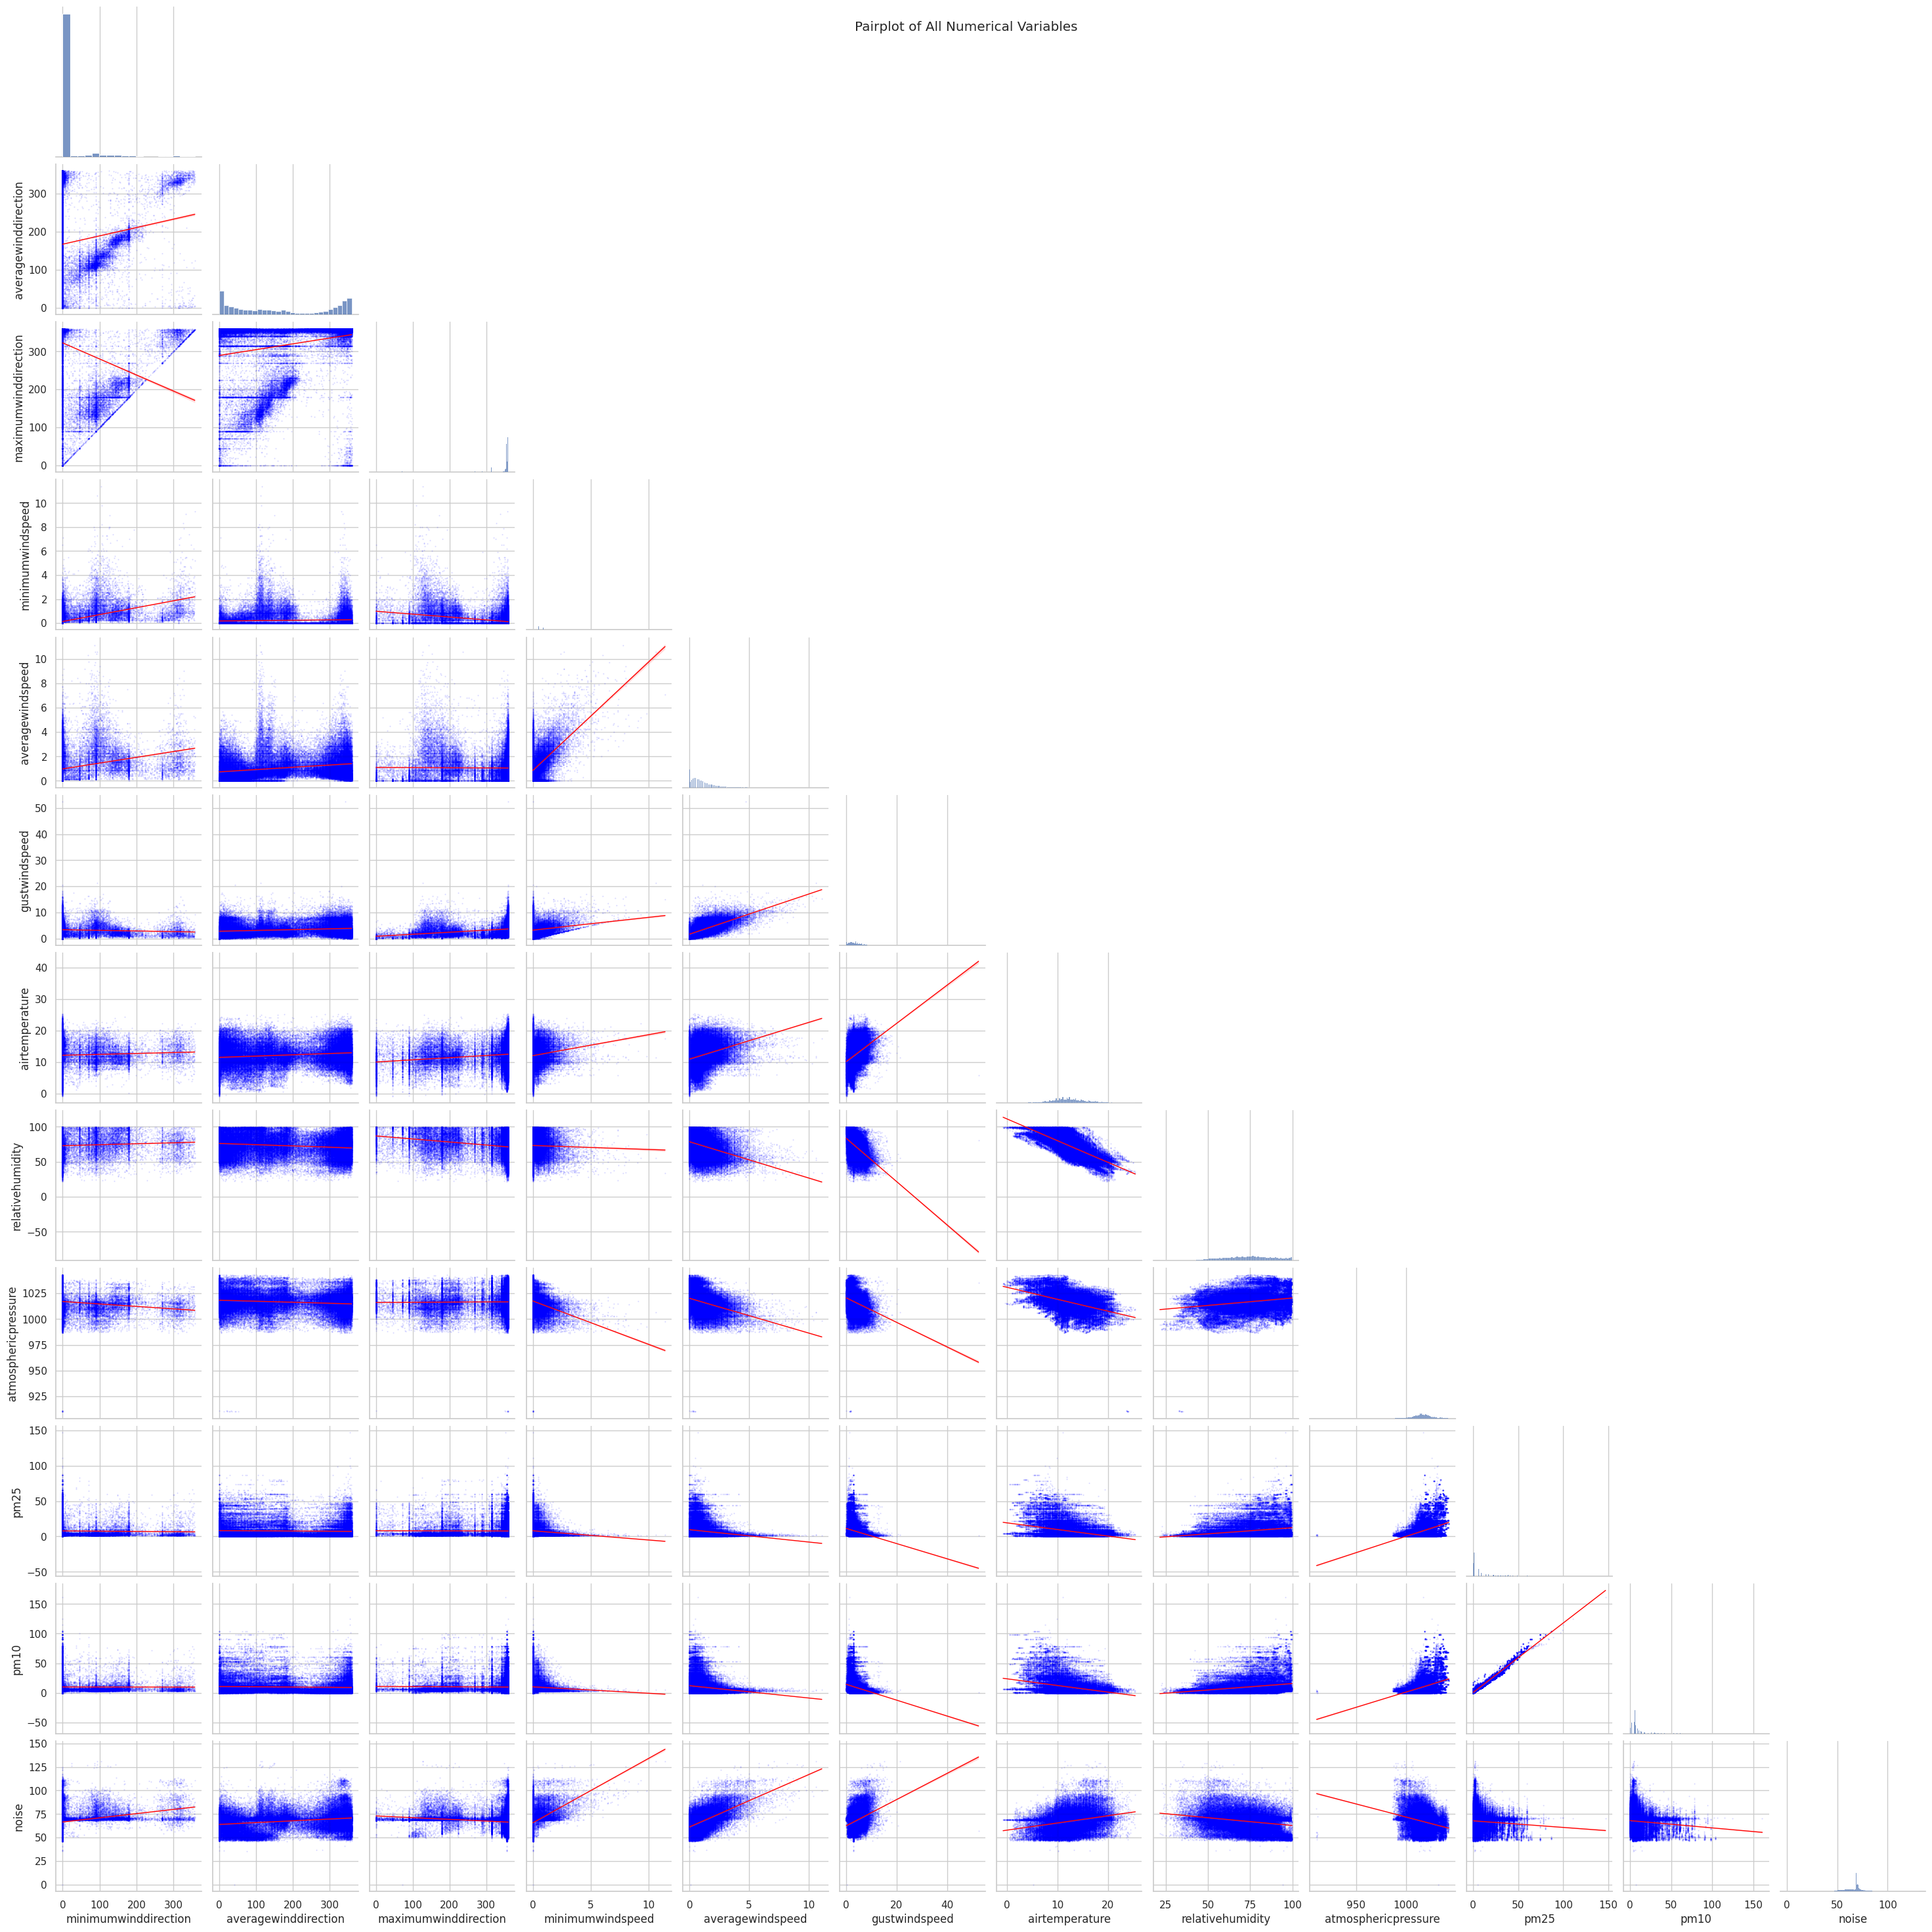

In [ ]:
pairplot = sns.pairplot(
    microclimate_sensors_df[microclimate_float_columns],
    corner=True,
    kind='reg',
    diag_kind='auto',
    plot_kws={'scatter_kws': {'s': 0.5, 'alpha': 0.1, 'color': 'blue'}, 'line_kws': {'color': 'red', 'linewidth': 1}}
)
pairplot.figure.suptitle('Pairplot of All Numerical Variables')
plt.show()

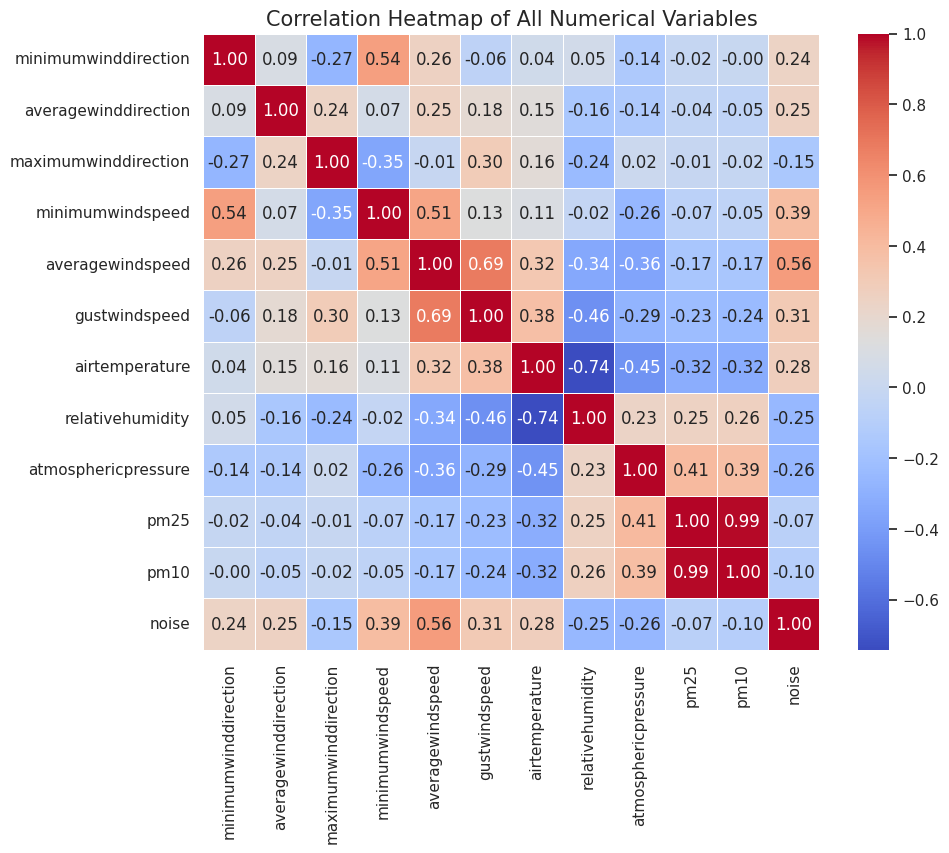

In [ ]:
# Create a heatmap using the correlation matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    microclimate_sensors_df[microclimate_float_columns].corr(),
    annot=True,  # Display the correlation values
    cmap='coolwarm',  # Color map
    fmt=".2f",  # Format the correlation values to two decimal places
    linewidths=0.5,  # Add some space between the squares
    square=True  # Ensure the cells are square-shaped
)

# Add title to the plot
plt.title('Correlation Heatmap of All Numerical Variables for Microclimate', size=15)
plt.show()

Looking at the correlation heatmap, here's how we can interpret the relationships to select parameters for predicting:

**PM2.5:**

* **Atmospheric Pressure:** Correlation of 0.41, moderately positive. This suggests that it is a good candidate for predicting PM2.5.
* **Relative Humidity:** Correlation of 0.25, moderately positive, though weaker than Atmospheric Pressure.
* **Air Temperature:** Correlation of -0.32, moderately negative.
* **Gust Wind Speed:** Slightly negative correlation at -0.23, but still worth considering due to its moderate strength.
* **Average Wind Speed:** Slightly negative correlation at -0.17, but still worth considering due to its nature.

**PM10:**

* **PM2.5:** Correlation of 0.99, extremely high. Since PM2.5 is nearly identical to PM10 in correlation, including PM2.5 in the model is crucial for predicting PM10.
* **Atmospheric Pressure:** Correlation of 0.39, moderate positive relationship.
* **Relative Humidity:** Correlation of 0.26, positive but weaker.
* **Air Temperature:** Slightly negative correlation at -0.32.
* **Gust Wind Speed:** Slightly negative correlation at -0.24, but still worth considering.
* **Average Wind Speed:** Slightly negative correlation at -0.17, but still worth considering due to its nature.

#### Feature Importance

A Decision Tree is an effective method for identifying important features because it inherently selects features that provide the most information gain at each split during the tree construction process. This makes it particularly well-suited for feature importance analysis, as it ranks features based on their contribution to reducing prediction error. Unlike some models that assume linear relationships between variables, Decision Trees can capture both linear and non-linear interactions between features and the target variable. Moreover, they handle different types of data without requiring normalization and are robust to irrelevant features, focusing only on the most predictive ones. This makes them a powerful tool for feature selection in diverse datasets.

In [ ]:
df_filtered = microclimate_sensors_df[microclimate_float_columns]

# Separate features (X) and targets (y) for PM2.5 and PM10
X = df_filtered.drop(columns=['pm25', 'pm10'])
y_pm25 = df_filtered['pm25']
y_pm10 = df_filtered['pm10']

# Split the data into training and test sets
X_train_pm25, X_test_pm25, y_train_pm25, y_test_pm25 = train_test_split(X, y_pm25, test_size=0.2, random_state=42)
X_train_pm10, X_test_pm10, y_train_pm10, y_test_pm10 = train_test_split(X, y_pm10, test_size=0.2, random_state=42)

# Initialize and train Decision Tree Regressor for PM2.5
dt_regressor_pm25 = DecisionTreeRegressor(random_state=42)
dt_regressor_pm25.fit(X_train_pm25, y_train_pm25)

# Initialize and train Decision Tree Regressor for PM10
dt_regressor_pm10 = DecisionTreeRegressor(random_state=42)
dt_regressor_pm10.fit(X_train_pm10, y_train_pm10)

# Extract feature importance
feature_importance_pm25 = dt_regressor_pm25.feature_importances_
feature_importance_pm10 = dt_regressor_pm10.feature_importances_

# Create a dataframe to show the feature importance for both models
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance_PM25': feature_importance_pm25,
    'Importance_PM10': feature_importance_pm10
}).sort_values(by='Importance_PM25', ascending=False)

# Display the feature importance dataframe
feature_importance_df

Feature  Importance_PM25  Importance_PM10
8   atmosphericpressure         0.350212         0.335914
6        airtemperature         0.144305         0.153030
7      relativehumidity         0.134141         0.138754
9                 noise         0.091778         0.095631
5         gustwindspeed         0.085555         0.094950
1  averagewinddirection         0.068889         0.069287
4      averagewindspeed         0.055288         0.051798
2  maximumwinddirection         0.044588         0.042161
3      minimumwindspeed         0.018007         0.012797
0  minimumwinddirection         0.007237         0.005679

Based on both the **correlation analysis** and the **feature importance** from the Decision Tree Regressor, we can combine the two methods to finalize the top 5 features for predicting PM2.5 and PM10.

**Decision Tree Feature Importance:**

* **Atmospheric Pressure** and **Air Temperature** were the top features for both PM2.5 and PM10 predictions.
* **Relative Humidity** and **Gust Wind Speed** also scored high in importance.
* **Noise** showed significant importance in both predictions.

By combining the results from both correlation and feature importance, the final 5 features for predicting PM2.5 and PM10 should be:

* **Atmospheric Pressure:** Highest importance from both correlation and decision tree.
* **Air Temperature:** Strong feature in both analyses.
* **Relative Humidity:** Moderate correlation and strong feature importance.
* **Noise:** Significant in feature importance.
* **Gust Wind Speed:** Showed moderate importance in the decision tree and some relationship in the data.

#### Location Analysis

In [ ]:
# Extract unique Device ID and LatLong data
device_location_data = microclimate_sensors_df[['device_id', 'latlong']].dropna().drop_duplicates()

# Split LatLong into separate Latitude and Longitude columns
device_location_data[['lat', 'long']] = device_location_data['latlong'].str.split(',', expand=True)
device_location_data['lat'] = device_location_data['lat'].astype(float)
device_location_data['long'] = device_location_data['long'].astype(float)

# Create a folium map centered around the average latitude and longitude of the sensors
map_center = [device_location_data['lat'].mean(), device_location_data['long'].mean()]
device_map = folium.Map(location=map_center, zoom_start=12)

# Add a marker cluster for better visualization of multiple device locations
device_marker_cluster = MarkerCluster().add_to(device_map)

# Add markers for each unique Device ID
for index, row in device_location_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=row['device_id'],
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(device_marker_cluster)

# Display the map
device_map

Since the sensor locations are fairly close to each other in the dataset, it is reasonable to aggregate the data and compute an average for each sensor across the entire Melbourne city region. By aggregating the sensor readings, we can simplify the analysis and obtain an overall average of air quality or other parameters for the city, rather than focusing on individual, closely located sensors. This aggregation can provide a more generalized view of the environmental conditions in Melbourne without the noise introduced by small variations between sensors in close proximity.

### Argyle Square Air Quality

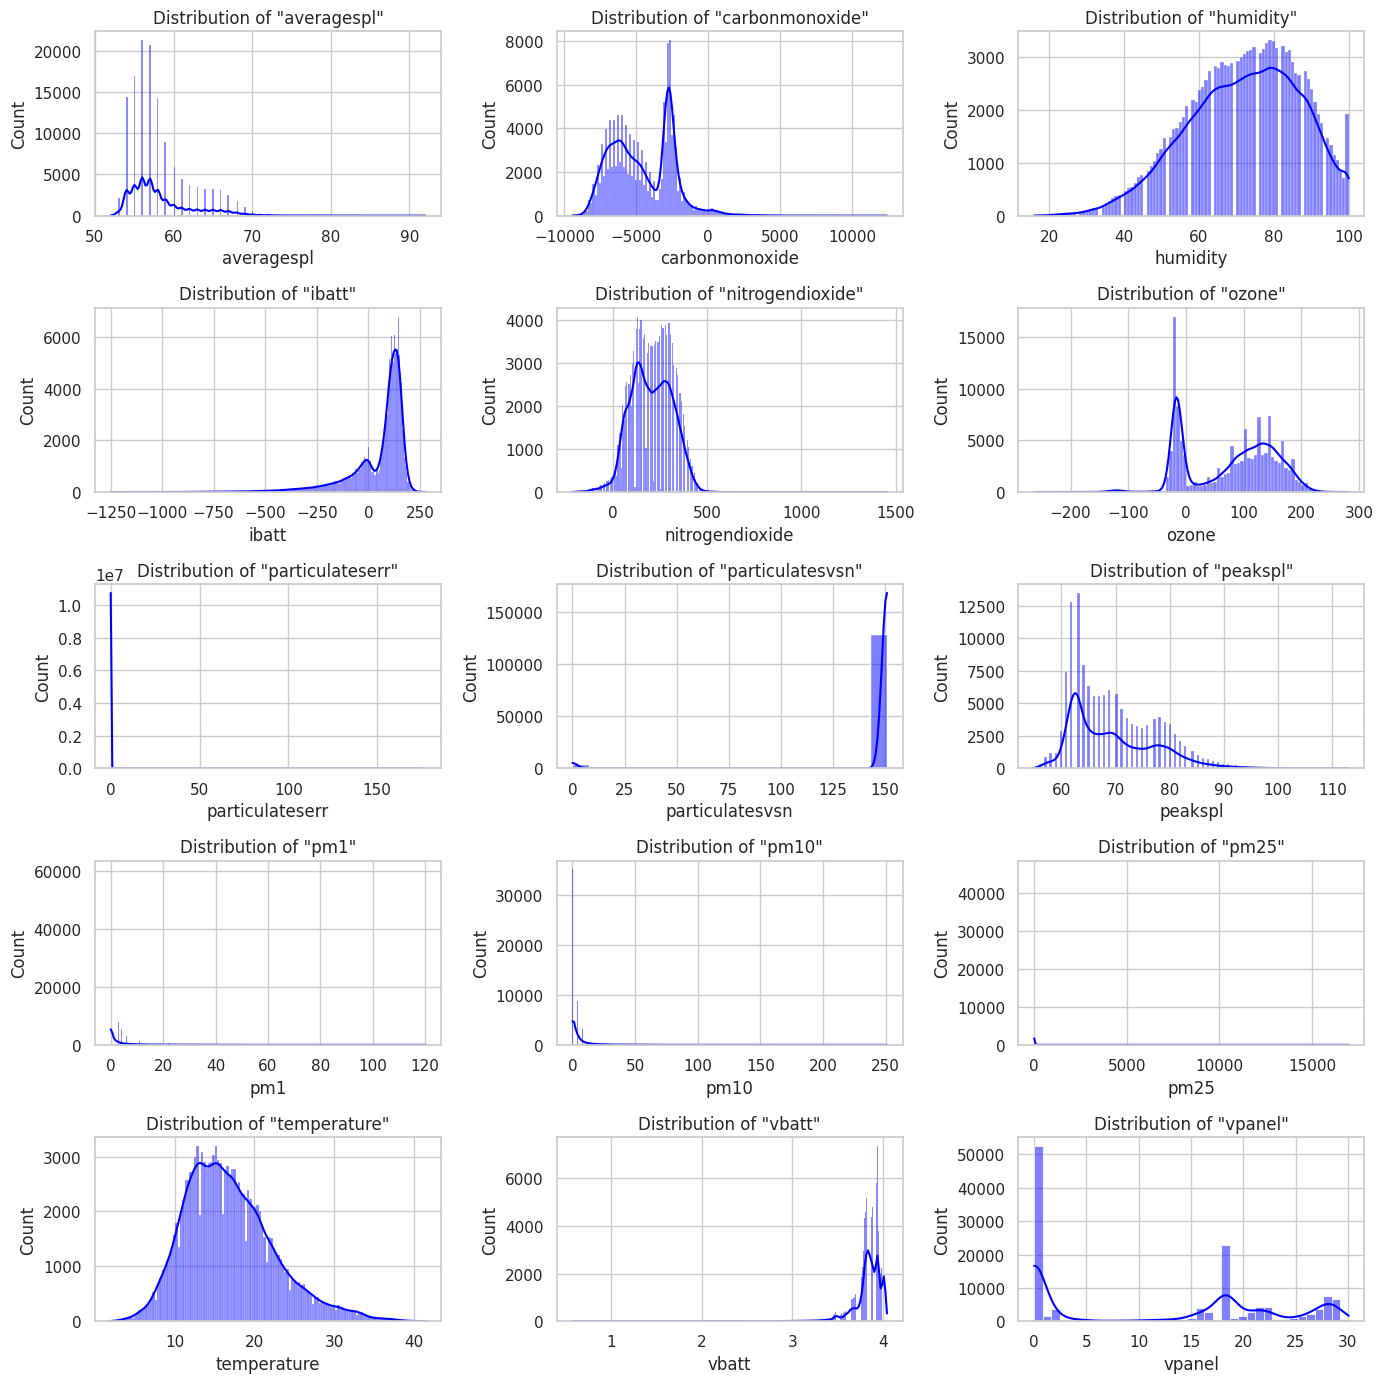

In [ ]:
# Setting the aesthetics for the plots
sns.set_theme(style="whitegrid")

# Selecting only the numerical columns for the pairplot
float_columns = [col for col in argyle_air_quality_df.select_dtypes(include=['float64']).columns if col not in ['lat', 'long']]

# Plotting the distribution of key variables
fig, axes = plt.subplots(5, 3, figsize=(14, 14))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, col_name in enumerate(float_columns):
    sns.histplot(argyle_air_quality_df[col_name], kde=True, ax=axes[i], color='blue')
    axes[i].set_title(f'Distribution of "{col_name}"')
    axes[i].set_xlabel('')  # Remove x-axis label
    axes[i].set_ylabel('')  # Remove y-axis label
    axes[i].set_xlabel(col_name)  # Add x-axis label
    axes[i].set_ylabel('Count')  # Add y-axis label

plt.tight_layout()
plt.show()

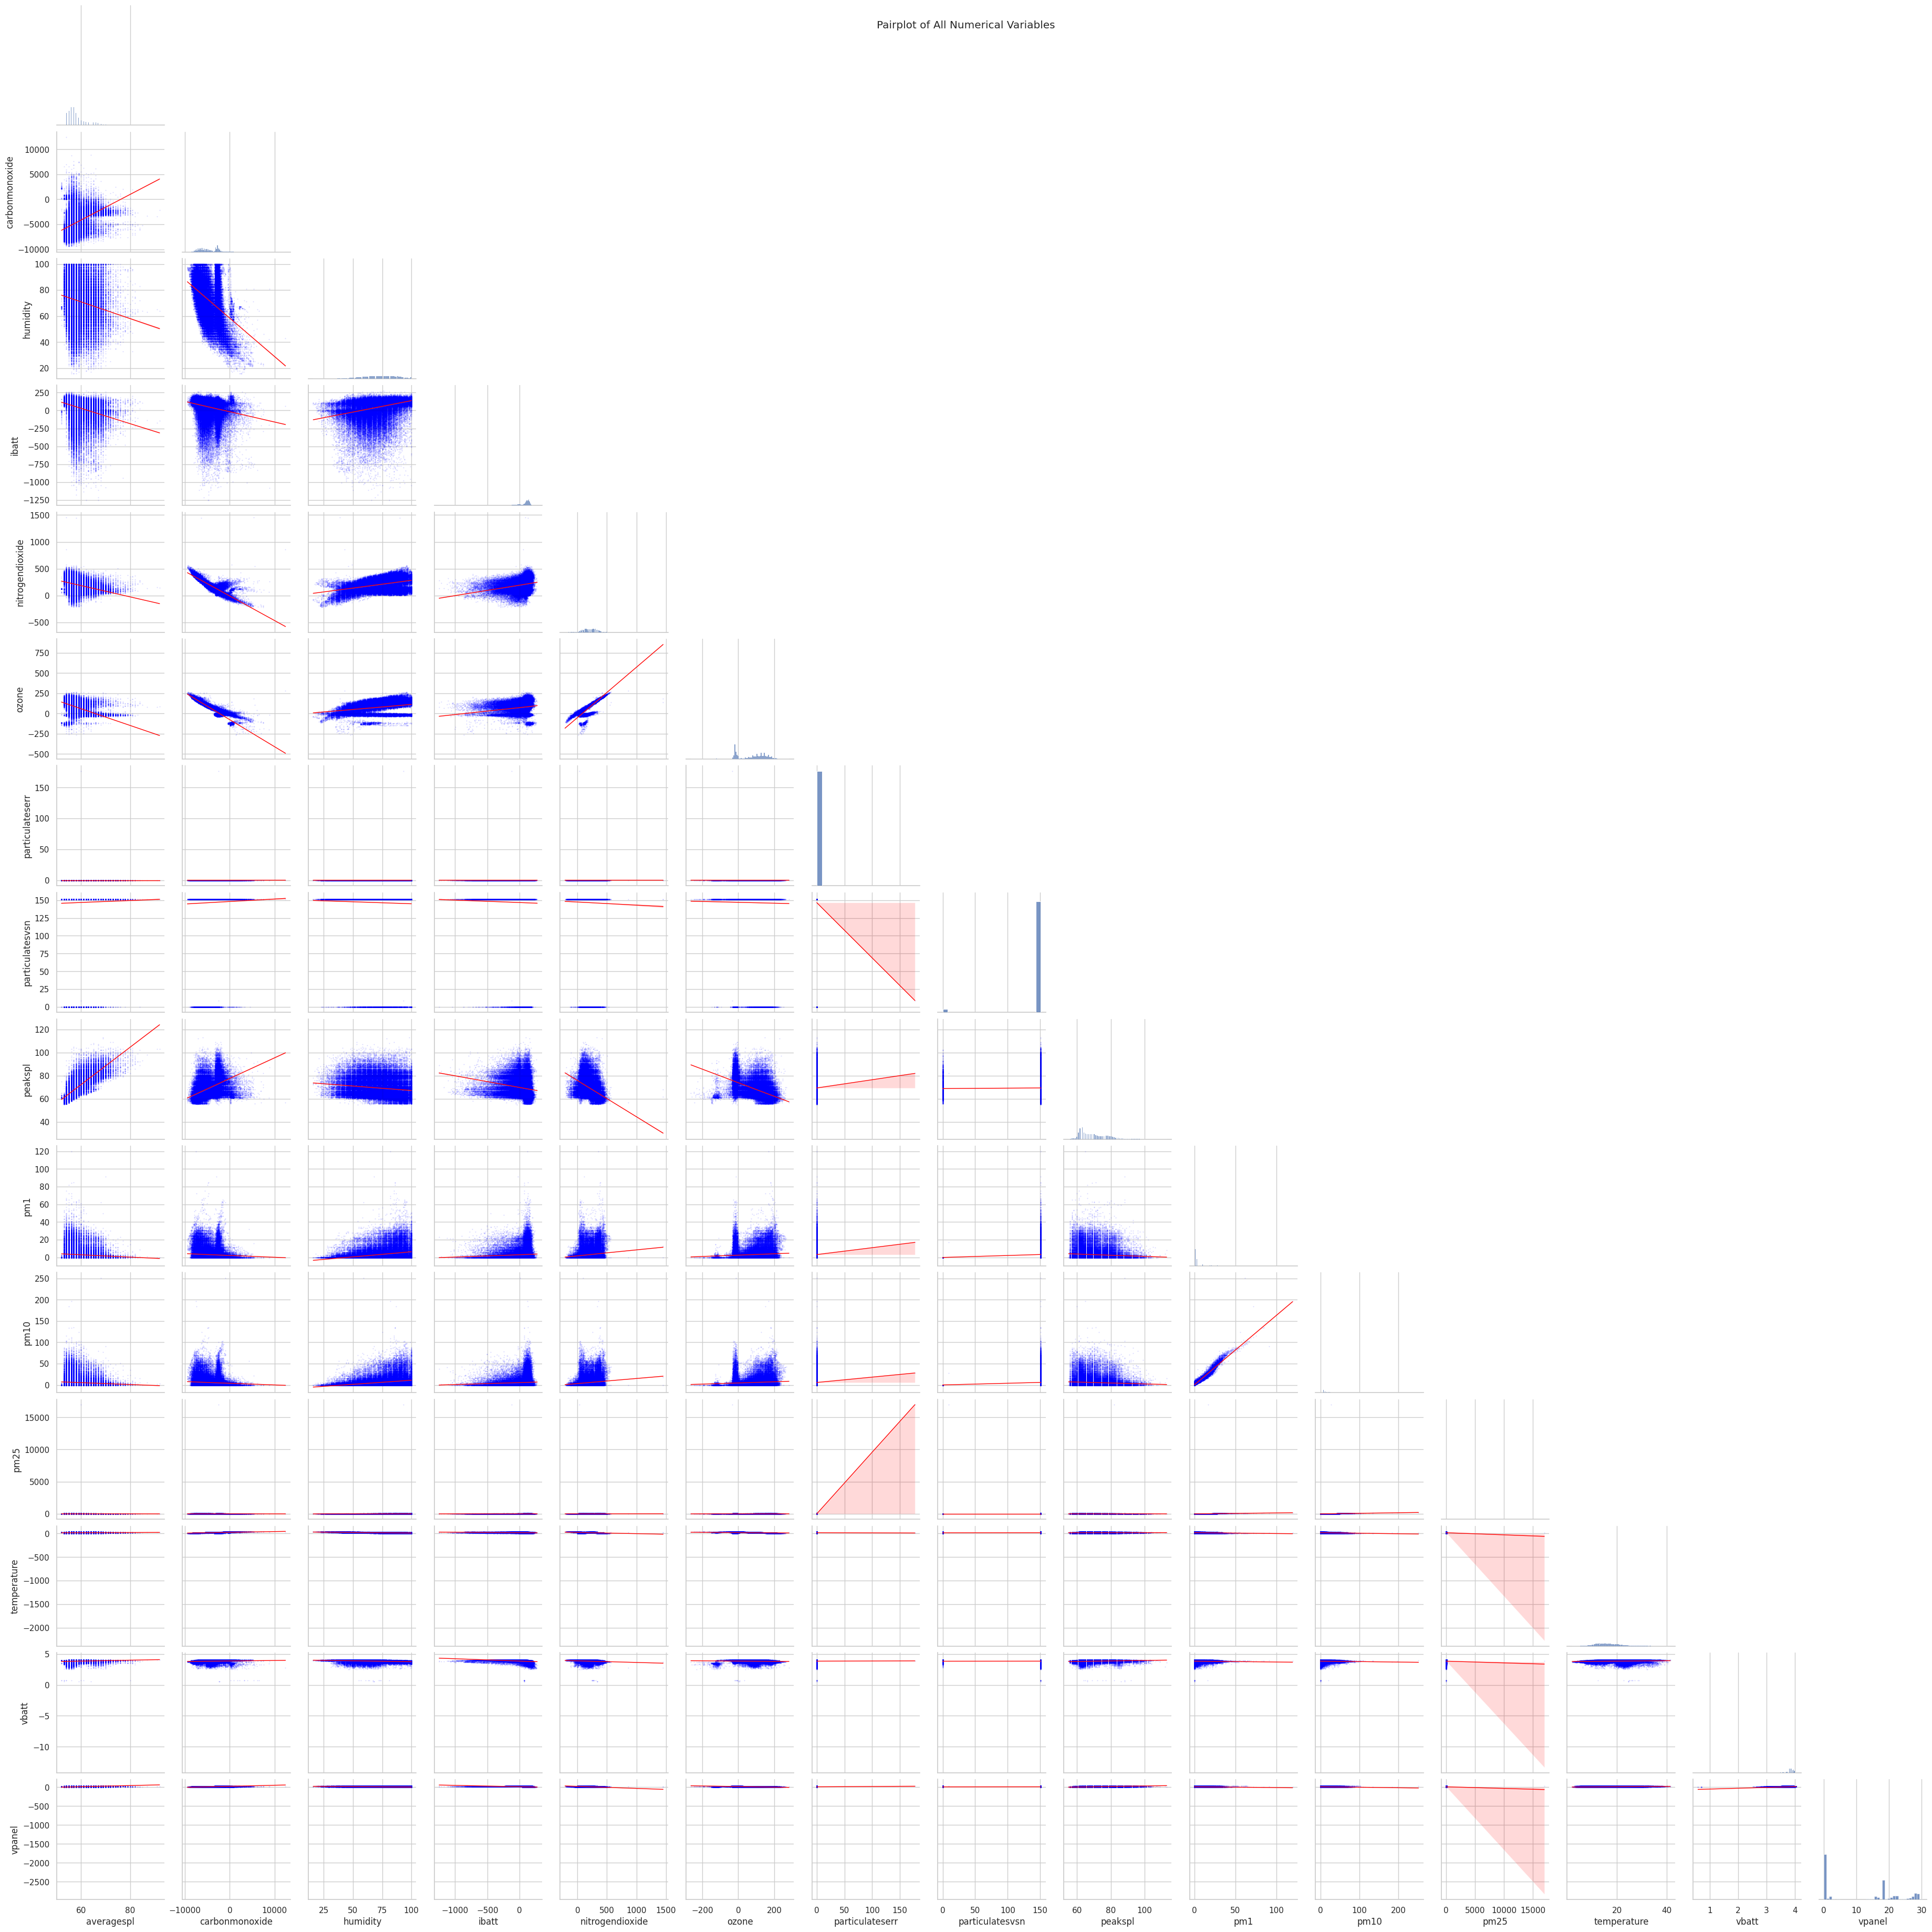

In [ ]:
pairplot = sns.pairplot(
    argyle_air_quality_df[float_columns],
    corner=True,
    kind='reg',
    diag_kind='auto',
    plot_kws={'scatter_kws': {'s': 0.5, 'alpha': 0.1, 'color': 'blue'}, 'line_kws': {'color': 'red', 'linewidth': 1}}
)
pairplot.figure.suptitle('Pairplot of All Numerical Variables')
plt.show()

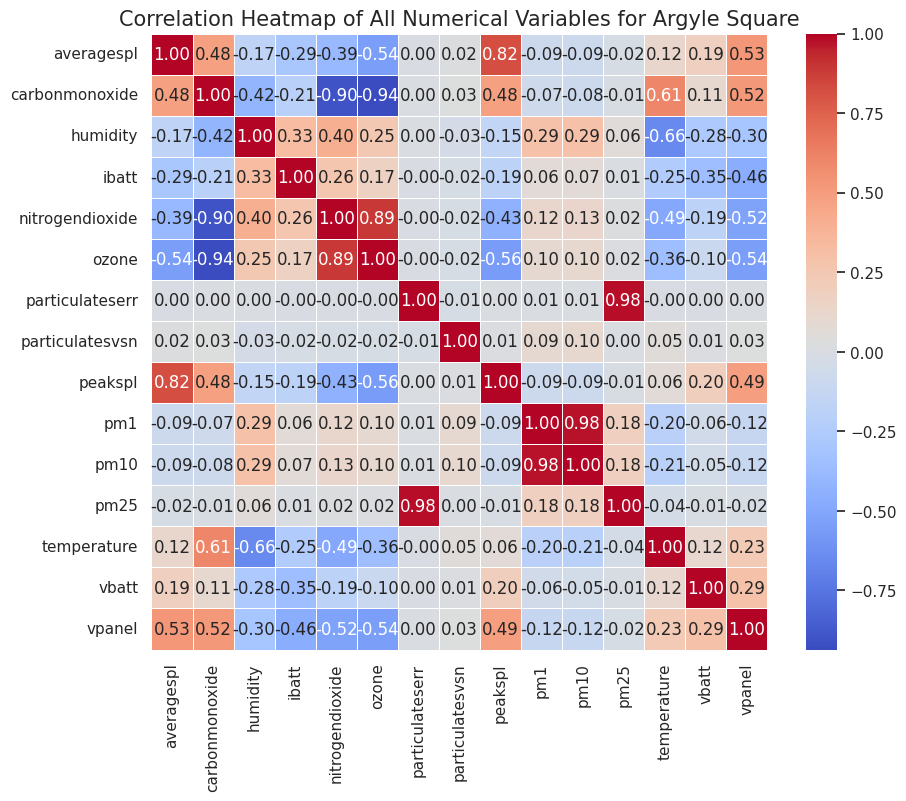

In [ ]:
# Create a heatmap using the correlation matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    argyle_air_quality_df[float_columns].corr(),
    annot=True,  # Display the correlation values
    cmap='coolwarm',  # Color map
    fmt=".2f",  # Format the correlation values to two decimal places
    linewidths=0.5,  # Add some space between the squares
    square=True  # Ensure the cells are square-shaped
)

# Add title to the plot
plt.title('Correlation Heatmap of All Numerical Variables for Argyle Square', size=15)
plt.show()

In [ ]:
# Extract unique Device ID and LatLong data
sensor_data = argyle_air_quality_df[['dev_id', 'sensor_name', 'lat_long']].drop_duplicates()

# Split lat_long into separate Latitude and Longitude columns
sensor_data[['Latitude', 'Longitude']] = sensor_data['lat_long'].str.split(',', expand=True)
sensor_data['Latitude'] = sensor_data['Latitude'].astype(float)
sensor_data['Longitude'] = sensor_data['Longitude'].astype(float)

# Create a folium map centered around the average latitude and longitude of the sensors
map_center = [sensor_data['Latitude'].mean(), sensor_data['Longitude'].mean()]
sensor_map = folium.Map(location=map_center, zoom_start=12)

# Add a marker cluster for better visualization of multiple sensors
marker_cluster = MarkerCluster().add_to(sensor_map)

# Add markers for each unique sensor
for index, row in sensor_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['sensor_name'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster)

# Display the map
sensor_map


## Method 1

### Data Wrangling

In this approach, the goal is to predict future air quality using the historical data of **PM2.5** and **PM10** from multiple sensors across different datasets. Each dataset contains readings from various sensors located in different parts of Melbourne. The first step is to resample the data for each sensor to hourly intervals, ensuring that the readings are aligned on a common time grid. Once the data is resampled, the next step is to aggregate the values from all the sensors to get an overall view of the air quality conditions in Melbourne. This involves calculating the median of the PM2.5 and PM10 values across all sensors for each hour. Finally, any missing time points in the data will be estimated using first-degree (linear) interpolation, ensuring that the dataset is complete and ready for further analysis. This processed dataset will then be used to predict future air quality based on the historical values of PM2.5 and PM10.








#### Microclimate

In [ ]:
# Group the data by device_id
sensor_groups = microclimate_sensors_df.groupby('device_id')

# Prepare an empty dictionary to store sequences for each sensor
sensor_sequences = {}

# Iterate over each sensor group and process data independently
for sensor_id, sensor_data in sensor_groups:
  # Select only relevant columns for LSTM model (Time, PM25, PM10)
  sensor_data = sensor_data[['received_at', 'pm25', 'pm10']]

  # Sort by time to ensure proper time series ordering
  sensor_data = sensor_data.sort_values(by='received_at')

  # Set 'Time' as the index (optional, but useful for resampling)
  sensor_data.set_index('received_at', inplace=True)

  # Resample to a consistent interval (e.g., hourly) if necessary
  sensor_data = sensor_data.resample('H').median()

  # Find the missing hours by comparing the full range with your dataset's 'Time' column
  missing_hours = pd.date_range(start=sensor_data.index.min(), end=sensor_data.index.max(), freq='H').difference(sensor_data.index)

  # Columns with missing values and the count of missing values
  missing_values = sensor_data.isnull().sum()
  missing_columns = missing_values[missing_values > 0]

  # Check the missing hours or values
  if len(missing_hours) != 0 and not missing_columns.empty:
      print("There are some missing time or value")

  # Store the sequences for this sensor
  sensor_sequences[sensor_id] = sensor_data

print(sensor_sequences['ICTMicroclimate-09'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2674 entries, 2024-05-29 03:00:00+00:00 to 2024-09-17 12:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm25    2673 non-null   float64
 1   pm10    2673 non-null   float64
dtypes: float64(2)
memory usage: 62.7 KB
None


#### Argyle Square

In [ ]:
# Group the data by dev_id
sensor_groups = argyle_air_quality_df.groupby('dev_id')

# Iterate over each sensor group and process data independently
for sensor_id, sensor_data in sensor_groups:
  # Select only relevant columns for LSTM model (Time, PM25, PM10)
  sensor_data = sensor_data[['time', 'pm25', 'pm10']]

  # Sort by time to ensure proper time series ordering
  sensor_data = sensor_data.sort_values(by='time')

  # Set 'Time' as the index (optional, but useful for resampling)
  sensor_data.set_index('time', inplace=True)

  # Resample to a consistent interval (e.g., hourly) if necessary
  sensor_data = sensor_data.resample('H').median()

  # Find the missing hours by comparing the full range with your dataset's 'Time' column
  missing_hours = pd.date_range(start=sensor_data.index.min(), end=sensor_data.index.max(), freq='H').difference(sensor_data.index)

  # Columns with missing values and the count of missing values
  missing_values = sensor_data.isnull().sum()
  missing_columns = missing_values[missing_values > 0]

  # Check the missing hours or values
  if len(missing_hours) != 0 and not missing_columns.empty:
      print("There are some missing time or value")

  # Store the sequences for this sensor
  sensor_sequences[sensor_id] = sensor_data

print(sensor_sequences['ems-ec8a'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35421 entries, 2020-06-09 08:00:00+00:00 to 2024-06-24 04:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm25    26849 non-null  float64
 1   pm10    26849 non-null  float64
dtypes: float64(2)
memory usage: 830.2 KB
None


In [ ]:
# print the of sensor_sequences with start and end time and number of records

for sensor_id, sensor_data in sensor_sequences.items():
  print(f"Sensor ID: {sensor_id}")
  print(f"Start Time: {sensor_data.index.min()}")
  print(f"End Time: {sensor_data.index.max()}")
  print(f"Number of Records: {len(sensor_data)}")
  print("-" * 20)


Sensor ID: ICTMicroclimate-01
Start Time: 2024-05-29 03:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Number of Records: 2674
--------------------
Sensor ID: ICTMicroclimate-02
Start Time: 2024-05-29 03:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Number of Records: 2674
--------------------
Sensor ID: ICTMicroclimate-03
Start Time: 2024-05-29 03:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Number of Records: 2674
--------------------
Sensor ID: ICTMicroclimate-04
Start Time: 2024-05-29 03:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Number of Records: 2674
--------------------
Sensor ID: ICTMicroclimate-05
Start Time: 2024-07-01 21:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Number of Records: 1864
--------------------
Sensor ID: ICTMicroclimate-06
Start Time: 2024-05-29 03:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Number of Records: 2674
--------------------
Sensor ID: ICTMicroclimate-07
Start Time: 2024-05-29 03:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Nu

In [ ]:
# Create an empty list to store resampled data from all sensors
all_sensors_data = []
for sensor_id, sensor_data in sensor_sequences.items():
  all_sensors_data.append(sensor_data)

# Concatenate all sensor data into a single DataFrame
combined_data = pd.concat(all_sensors_data)

# Group by the time index and calculate the median to get hourly value across all sensors
hourly_data = combined_data.groupby(combined_data.index).median()

# Interpolate missing values linearly (optional)
hourly_data = hourly_data.interpolate(method='linear')

# Print the first few rows of the final hourly data
print(f"Start Time: {hourly_data.index.min()}")
print(f"End Time: {hourly_data.index.max()}")
print(f"Number of Records: {len(hourly_data)}")
print("-" * 20)

hourly_data.head()

Start Time: 2020-06-09 08:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Number of Records: 37469
--------------------


pm25  pm10
2020-06-09 08:00:00+00:00  17.0  18.0
2020-06-09 09:00:00+00:00  15.0  18.0
2020-06-09 10:00:00+00:00  16.0  18.5
2020-06-09 11:00:00+00:00  23.0  26.5
2020-06-09 12:00:00+00:00  26.0  29.0

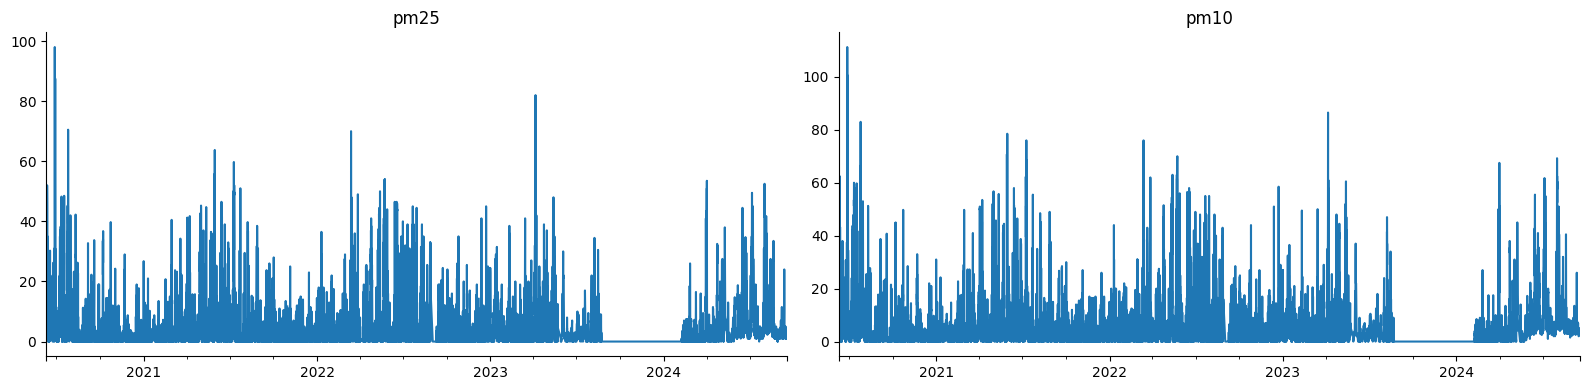

In [ ]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot pm25 on the first subplot
hourly_data['pm25'].plot(kind='line', ax=axes[0], title='pm25')
axes[0].spines[['top', 'right']].set_visible(False)

# Plot pm10 on the second subplot
hourly_data['pm10'].plot(kind='line', ax=axes[1], title='pm10')
axes[1].spines[['top', 'right']].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler to 'pm25' and 'pm10' columns
hourly_data[['pm25', 'pm10']] = scaler.fit_transform(hourly_data[['pm25', 'pm10']])

hourly_data.head()

pm25      pm10
2020-06-09 08:00:00+00:00  0.173469  0.161798
2020-06-09 09:00:00+00:00  0.153061  0.161798
2020-06-09 10:00:00+00:00  0.163265  0.166292
2020-06-09 11:00:00+00:00  0.234694  0.238202
2020-06-09 12:00:00+00:00  0.265306  0.260674

Between late August 22, 2023, and February 7, 2024, the data appears to be consistently low, which could suggest either a period of minimal pollution or possible issues with sensor data collection, such as missing data or sensor downtimes. I will keep this in mind when preparing the data and ensure that no samples are taken from this period.

In [ ]:
# Filter out the period from August 22, 2023, to February 7, 2024
hourly_data = hourly_data[(hourly_data.index < '2023-08-22') | (hourly_data.index > '2024-02-07')]

# Function to create sequences of the last 24 hours to predict the next time step
def create_sequences(data, n_steps=24):
  X, y = [], []
  for i in range(len(data) - n_steps):
      X.append(data[i:i + n_steps])
      y.append(data[i + n_steps])
  return np.array(X), np.array(y)

# Use 'pm25' and 'pm10' columns to create sequences
data_values = hourly_data[['pm25', 'pm10']].values
X, y = create_sequences(data_values)

In [ ]:
# Split the data into train (70%), validation (15%), and test sets (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print the shapes of the train, validation, and test sets
print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Validation set shape: {X_valid.shape}, {y_valid.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Training set shape: (23371, 24, 2), (23371, 2)
Validation set shape: (5008, 24, 2), (5008, 2)
Test set shape: (5009, 24, 2), (5009, 2)


### Deep Learning Model

#### LSTM

In [ ]:
# Define the LSTM model
lstm_model_1 = Sequential()
lstm_model_1.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer with shape (24 timesteps, 2 features: pm25 and pm10)
lstm_model_1.add(LSTM(32, activation='relu', return_sequences=True)) # First LSTM layer with 32 units, returning sequences to the next LSTM layer
lstm_model_1.add(LSTM(16, activation='relu', return_sequences=True)) # Second LSTM layer with 16 units, returning sequences to the next LSTM layer
lstm_model_1.add(LSTM(8, activation='relu')) # Third LSTM layer with 8 units, returning only the final output
lstm_model_1.add(Dense(2)) # Output layer with 2 neurons to predict both pm25 and pm10

# Compile the model with Adam optimizer and learning rate of 0.001
lstm_model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_lstm_model_1.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
lstm_history_1 = lstm_model_1.fit(X_train, y_train,
                                  epochs=100,
                                  validation_data=(X_valid, y_valid),
                                  callbacks=[early_stopping, checkpoint])

Epoch 1/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0826 - val_loss: 0.0121
Epoch 2/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0104 - val_loss: 0.0022
Epoch 3/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 4/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 6/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 8/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 10/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 11/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 12/100
731/731 ━━━

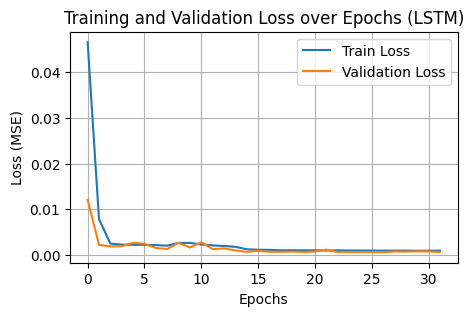

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(lstm_history_1.history['loss'], label='Train Loss')
plt.plot(lstm_history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = lstm_model_1.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9764e-04
Test Loss: 0.0004461882926989347


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


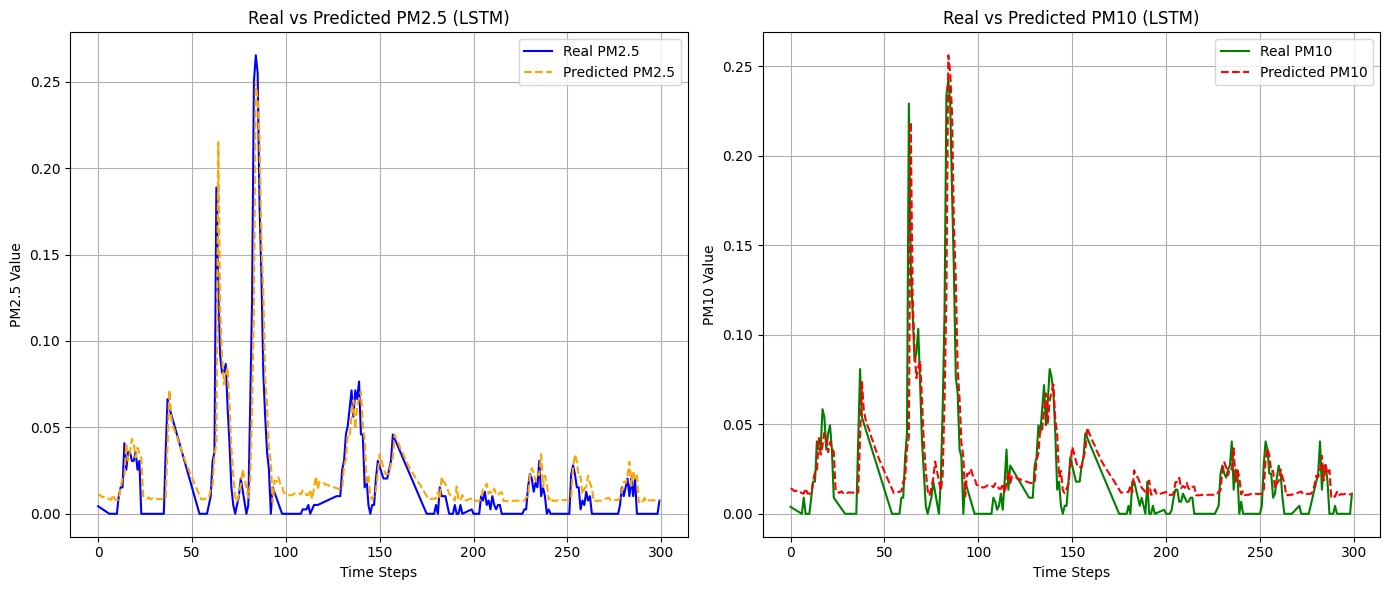

In [ ]:
# Predict on the test set
y_pred = lstm_model_1.predict(X_test)

# Extract the real and predicted values for pm25 and pm10
num_samples = 300
real_pm25 = y_test[:num_samples, 0]
real_pm10 = y_test[:num_samples, 1]
predicted_pm25 = y_pred[:num_samples, 0]
predicted_pm10 = y_pred[:num_samples, 1]

# Plotting the real and predicted values for pm25 and pm10 in two subplots
plt.figure(figsize=(14, 6))

# Subplot 1 for PM2.5
plt.subplot(1, 2, 1)
plt.plot(real_pm25, label='Real PM2.5', color='blue')
plt.plot(predicted_pm25, label='Predicted PM2.5', color='orange', linestyle='--')
plt.title('Real vs Predicted PM2.5 (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.grid(True)

# Subplot 2 for PM10
plt.subplot(1, 2, 2)
plt.plot(real_pm10, label='Real PM10', color='green')
plt.plot(predicted_pm10, label='Predicted PM10', color='red', linestyle='--')
plt.title('Real vs Predicted PM10 (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('PM10 Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### GRU


In [ ]:
# Define the GRU model
gru_model_1 = Sequential()
gru_model_1.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer with shape (24 timesteps, 2 features: pm25 and pm10)
gru_model_1.add(GRU(32, activation='relu', return_sequences=True)) # First LSTM layer with 32 units, returning sequences to the next LSTM layer
gru_model_1.add(GRU(16, activation='relu', return_sequences=True)) # Second LSTM layer with 16 units, returning sequences to the next LSTM layer
gru_model_1.add(GRU(8, activation='relu')) # Third LSTM layer with 8 units, returning only the final output
gru_model_1.add(Dense(2)) # Output layer with 2 neurons to predict both pm25 and pm10

# Compile the model with Adam optimizer and learning rate of 0.001
gru_model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_gru_model_1.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
gru_history_1 = gru_model_1.fit(X_train, y_train,
                                  epochs=100,
                                  validation_data=(X_valid, y_valid),
                                  callbacks=[early_stopping, checkpoint])

Epoch 1/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0028 - val_loss: 6.4584e-04
Epoch 2/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 9.2629e-04 - val_loss: 6.4507e-04
Epoch 3/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 8.7834e-04 - val_loss: 6.6083e-04
Epoch 4/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 9.7132e-04 - val_loss: 6.6739e-04
Epoch 5/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 9.3562e-04 - val_loss: 6.3789e-04
Epoch 6/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 9.6577e-04 - val_loss: 6.5164e-04
Epoch 7/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 9.2632e-04 - val_loss: 6.4041e-04
Epoch 8/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0010 - val_loss: 6.2361e-04
Epoch 9/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 9.3825e-04 - val_loss: 6.6791e-04
Epoch 10/100
731/731 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 9.3960e-04 - val_loss: 6.3782e-04
Epoch 11/100
731/731 ━━━━━━━━━━━━━━━━

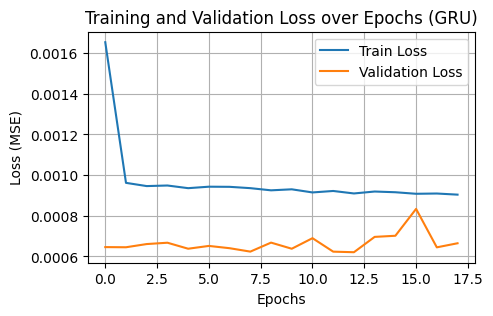

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(gru_history_1.history['loss'], label='Train Loss')
plt.plot(gru_history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = gru_model_1.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6584e-04
Test Loss: 0.000416912225773558


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


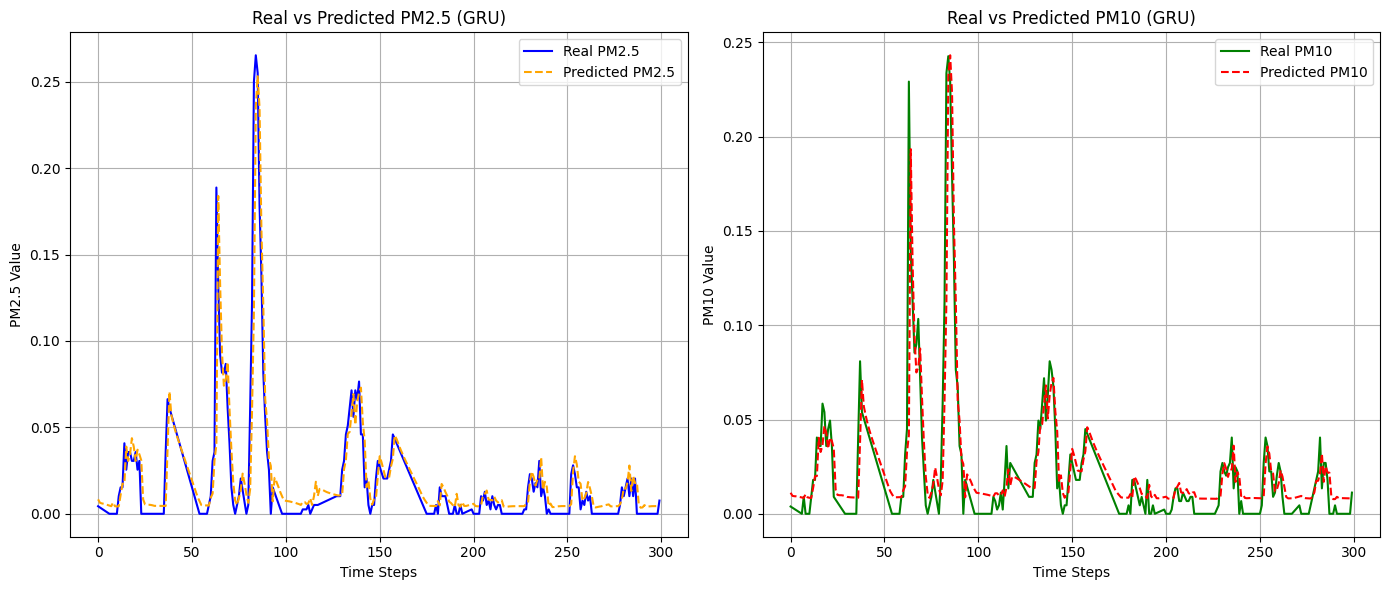

In [ ]:
# Predict on the test set
y_pred = gru_model_1.predict(X_test)

# Extract the real and predicted values for pm25 and pm10
num_samples = 300
real_pm25 = y_test[:num_samples, 0]
real_pm10 = y_test[:num_samples, 1]
predicted_pm25 = y_pred[:num_samples, 0]
predicted_pm10 = y_pred[:num_samples, 1]

# Plotting the real and predicted values for pm25 and pm10 in two subplots
plt.figure(figsize=(14, 6))

# Subplot 1 for PM2.5
plt.subplot(1, 2, 1)
plt.plot(real_pm25, label='Real PM2.5', color='blue')
plt.plot(predicted_pm25, label='Predicted PM2.5', color='orange', linestyle='--')
plt.title('Real vs Predicted PM2.5 (GRU)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.grid(True)

# Subplot 2 for PM10
plt.subplot(1, 2, 2)
plt.plot(real_pm10, label='Real PM10', color='green')
plt.plot(predicted_pm10, label='Predicted PM10', color='red', linestyle='--')
plt.title('Real vs Predicted PM10 (GRU)')
plt.xlabel('Time Steps')
plt.ylabel('PM10 Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The LSTM and GRU models both perform well in predicting future PM2.5 and PM10 values based on historical data, with LSTM showing slightly better accuracy in capturing sharp spikes, particularly for PM10, while GRU exhibits more deviation during peaks. However, GRU has a marginally lower test loss (0.0004169 vs. LSTM's 0.0004462), indicating it made fewer overall errors in prediction. While LSTM might be preferable for scenarios where sharp fluctuations in air quality are critical, GRU's efficiency and lower complexity make it a strong alternative, especially for general use cases. The choice between the two depends on whether accuracy in extreme events or computational efficiency is prioritized.

## Method 2


### Data Wrangling

The goal of this approach is to predict future air quality by focusing on the most important features related to PM2.5 and PM10: Atmospheric Pressure, Air Temperature, Relative Humidity, Noise, and Gust Wind Speed. To achieve this, we will use the Microclimate Sensor dataset, which contains readings from various sensors across Melbourne. The first step is to resample the data from each sensor to hourly intervals to align all the readings on a consistent time grid. After resampling, we will aggregate the values from all sensors to get an overall view of Melbourne's air quality by calculating the median of each feature across all sensors for each hour. Finally, any missing time points will be estimated using linear interpolation to ensure a complete dataset for analysis. This processed dataset will then be used to predict future air quality based on historical data.

In [ ]:
# Group the data by device_id
sensor_groups = microclimate_sensors_df.groupby('device_id')

# Prepare an empty dictionary to store sequences for each sensor
sensor_sequences = {}

# Iterate over each sensor group and process data independently
for sensor_id, sensor_data in sensor_groups:
  # Select only relevant columns for LSTM model (Time, PM25, PM10)
  sensor_data = sensor_data[['received_at', 'pm25', 'pm10', 'atmosphericpressure', 'relativehumidity', 'airtemperature', 'gustwindspeed', 'noise']]

  # Sort by time to ensure proper time series ordering
  sensor_data = sensor_data.sort_values(by='received_at')

  # Set 'Time' as the index (optional, but useful for resampling)
  sensor_data.set_index('received_at', inplace=True)

  # Resample to a consistent interval (e.g., hourly) if necessary
  sensor_data = sensor_data.resample('H').median()

  # Find the missing hours by comparing the full range with your dataset's 'Time' column
  missing_hours = pd.date_range(start=sensor_data.index.min(), end=sensor_data.index.max(), freq='H').difference(sensor_data.index)

  # Columns with missing values and the count of missing values
  missing_values = sensor_data.isnull().sum()
  missing_columns = missing_values[missing_values > 0]

  # Check the missing hours or values
  if len(missing_hours) != 0 and not missing_columns.empty:
      print("There are some missing time or value")

  # Store the sequences for this sensor
  sensor_sequences[sensor_id] = sensor_data

print(sensor_sequences['ICTMicroclimate-09'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2674 entries, 2024-05-29 03:00:00+00:00 to 2024-09-17 12:00:00+00:00
Freq: H
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pm25                 2673 non-null   float64
 1   pm10                 2673 non-null   float64
 2   atmosphericpressure  2673 non-null   float64
 3   relativehumidity     2673 non-null   float64
 4   airtemperature       2673 non-null   float64
 5   gustwindspeed        2673 non-null   float64
 6   noise                2673 non-null   float64
dtypes: float64(7)
memory usage: 167.1 KB
None


In [ ]:
# Create an empty list to store resampled data from all sensors
all_sensors_data = []
for sensor_id, sensor_data in sensor_sequences.items():
  all_sensors_data.append(sensor_data)

# Concatenate all sensor data into a single DataFrame
combined_data = pd.concat(all_sensors_data)

# Group by the time index and calculate the median to get hourly value across all sensors
hourly_data = combined_data.groupby(combined_data.index).median()

# Interpolate missing values linearly (optional)
hourly_data = hourly_data.interpolate(method='linear')

# Print the first few rows of the final hourly data
print(f"Start Time: {hourly_data.index.min()}")
print(f"End Time: {hourly_data.index.max()}")
print(f"Number of Records: {len(hourly_data)}")
print("-" * 20)

hourly_data.head()

Start Time: 2024-05-29 03:00:00+00:00
End Time: 2024-09-17 12:00:00+00:00
Number of Records: 2674
--------------------


pm25   pm10  atmosphericpressure  relativehumidity  \
received_at                                                                     
2024-05-29 03:00:00+00:00  12.5  14.00          1019.399994            43.900   
2024-05-29 04:00:00+00:00  12.0  14.25          1019.149988            43.775   
2024-05-29 05:00:00+00:00  12.0  14.00          1018.800018            42.900   
2024-05-29 06:00:00+00:00  10.5  11.00          1018.500000            44.900   
2024-05-29 07:00:00+00:00  12.5  14.50          1018.649994            48.350   

                           airtemperature  gustwindspeed   noise  
received_at                                                       
2024-05-29 03:00:00+00:00           19.40          7.350  71.350  
2024-05-29 04:00:00+00:00           19.45          6.525  71.175  
2024-05-29 05:00:00+00:00           19.55          5.800  70.900  
2024-05-29 06:00:00+00:00           18.75          4.700  71.300  
2024-05-29 07:00:00+00:00           17.80          3.900  71.350

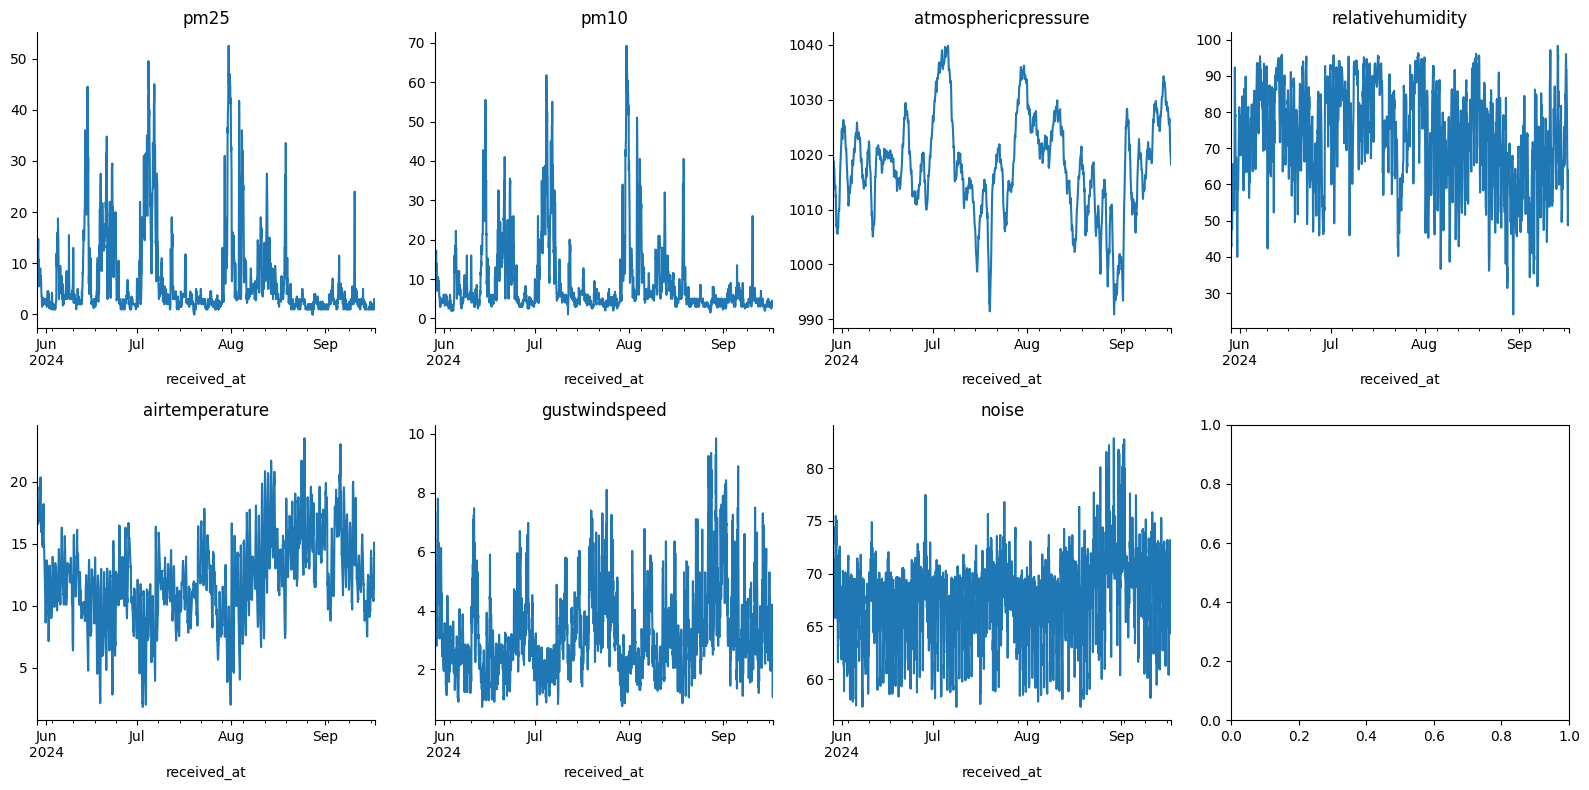

In [ ]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Plot pm25 on the first subplot
hourly_data['pm25'].plot(kind='line', ax=axes[0], title='pm25')
axes[0].spines[['top', 'right']].set_visible(False)

# Plot noise on the second subplot
hourly_data['pm10'].plot(kind='line', ax=axes[1], title='pm10')
axes[1].spines[['top', 'right']].set_visible(False)

# Plot atmosphericpressure on the second subplot
hourly_data['atmosphericpressure'].plot(kind='line', ax=axes[2], title='atmosphericpressure')
axes[2].spines[['top', 'right']].set_visible(False)

# Plot relativehumidity on the second subplot
hourly_data['relativehumidity'].plot(kind='line', ax=axes[3], title='relativehumidity')
axes[3].spines[['top', 'right']].set_visible(False)

# Plot airtemperature on the second subplot
hourly_data['airtemperature'].plot(kind='line', ax=axes[4], title='airtemperature')
axes[4].spines[['top', 'right']].set_visible(False)

# Plot gustwindspeed on the second subplot
hourly_data['gustwindspeed'].plot(kind='line', ax=axes[5], title='gustwindspeed')
axes[5].spines[['top', 'right']].set_visible(False)

# Plot noise on the second subplot
hourly_data['noise'].plot(kind='line', ax=axes[6], title='noise')
axes[6].spines[['top', 'right']].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler to 'pm25' and 'pm10' columns
hourly_data[['pm25', 'pm10', 'atmosphericpressure', 'relativehumidity', 'airtemperature', 'gustwindspeed', 'noise']] = scaler.fit_transform(hourly_data[['pm25', 'pm10', 'atmosphericpressure', 'relativehumidity', 'airtemperature', 'gustwindspeed', 'noise']])

hourly_data.head()

pm25      pm10  atmosphericpressure  \
received_at                                                          
2024-05-29 03:00:00+00:00  0.238095  0.190476             0.582227   
2024-05-29 04:00:00+00:00  0.228571  0.194139             0.577120   
2024-05-29 05:00:00+00:00  0.228571  0.190476             0.569970   
2024-05-29 06:00:00+00:00  0.200000  0.146520             0.563841   
2024-05-29 07:00:00+00:00  0.238095  0.197802             0.566905   

                           relativehumidity  airtemperature  gustwindspeed  \
received_at                                                                  
2024-05-29 03:00:00+00:00          0.266846        0.810624       0.726027   
2024-05-29 04:00:00+00:00          0.265162        0.812933       0.635616   
2024-05-29 05:00:00+00:00          0.253369        0.817552       0.556164   
2024-05-29 06:00:00+00:00          0.280323        0.780600       0.435616   
2024-05-29 07:00:00+00:00          0.326819        0.736721       0.347945   

                              noise  
received_at                          
2024-05-29 03:00:00+00:00  0.549020  
2024-05-29 04:00:00+00:00  0.542157  
2024-05-29 05:00:00+00:00  0.531373  
2024-05-29 06:00:00+00:00  0.547059  
2024-05-29 07:00:00+00:00  0.549020

In [ ]:
# Function to create sequences of the last 24 hours to predict the next time step
def create_sequences(data, n_steps=24):
  X, y = [], []
  for i in range(len(data) - n_steps):
      X.append(data[i:i + n_steps])
      y.append(data[i + n_steps][:2])
  return np.array(X), np.array(y)

# Use 'pm25' and 'pm10' columns to create sequences
data_values = hourly_data[['pm25', 'pm10', 'atmosphericpressure', 'relativehumidity', 'airtemperature', 'gustwindspeed', 'noise']].values
X, y = create_sequences(data_values)

In [ ]:
# Split the data into train (80%), validation (10%), and test sets (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print the shapes of the train, validation, and test sets
print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Validation set shape: {X_valid.shape}, {y_valid.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Training set shape: (2120, 24, 7), (2120, 2)
Validation set shape: (265, 24, 7), (265, 2)
Test set shape: (265, 24, 7), (265, 2)


### Deep Learning Model

#### LSTM

In [ ]:
# Define the LSTM model
lstm_model_2 = Sequential()
lstm_model_2.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer with shape (24 timesteps, 7 features)
lstm_model_2.add(LSTM(32, activation='relu', return_sequences=True)) # First LSTM layer with 32 units, returning sequences to the next LSTM layer
lstm_model_2.add(LSTM(16, activation='relu', return_sequences=True)) # Second LSTM layer with 16 units, returning sequences to the next LSTM layer
lstm_model_2.add(LSTM(8, activation='relu')) # Third LSTM layer with 8 units, returning only the final output
lstm_model_2.add(Dense(2)) # Output layer with 2 neurons to predict both pm25 and pm10

# Compile the model with Adam optimizer and learning rate of 0.001
lstm_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_lstm_model_2.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
lstm_history_2 = lstm_model_2.fit(X_train, y_train,
                                  epochs=100,
                                  validation_data=(X_valid, y_valid),
                                  callbacks=[early_stopping, checkpoint])

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - loss: 0.0451 - val_loss: 0.0014
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0138 - val_loss: 8.5071e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0093 - val_loss: 7.3592e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0077 - val_loss: 8.2320e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0074 - val_loss: 8.1421e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0047 - val_loss: 6.6603e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 6.3818e-04
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044 - val_loss: 5.9249e-04
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - val_loss: 7.3337e-04
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - val_loss: 7.1967e-04
Epoch 12/100
6

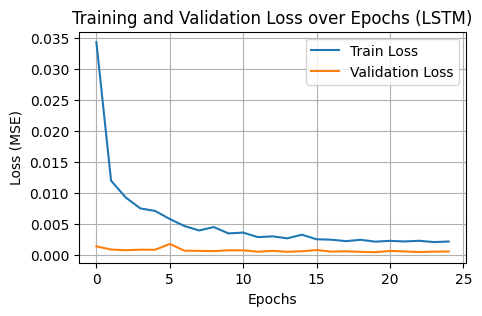

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(lstm_history_2.history['loss'], label='Train Loss')
plt.plot(lstm_history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = lstm_model_2.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9719e-04
Test Loss: 0.0009264189284294844


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


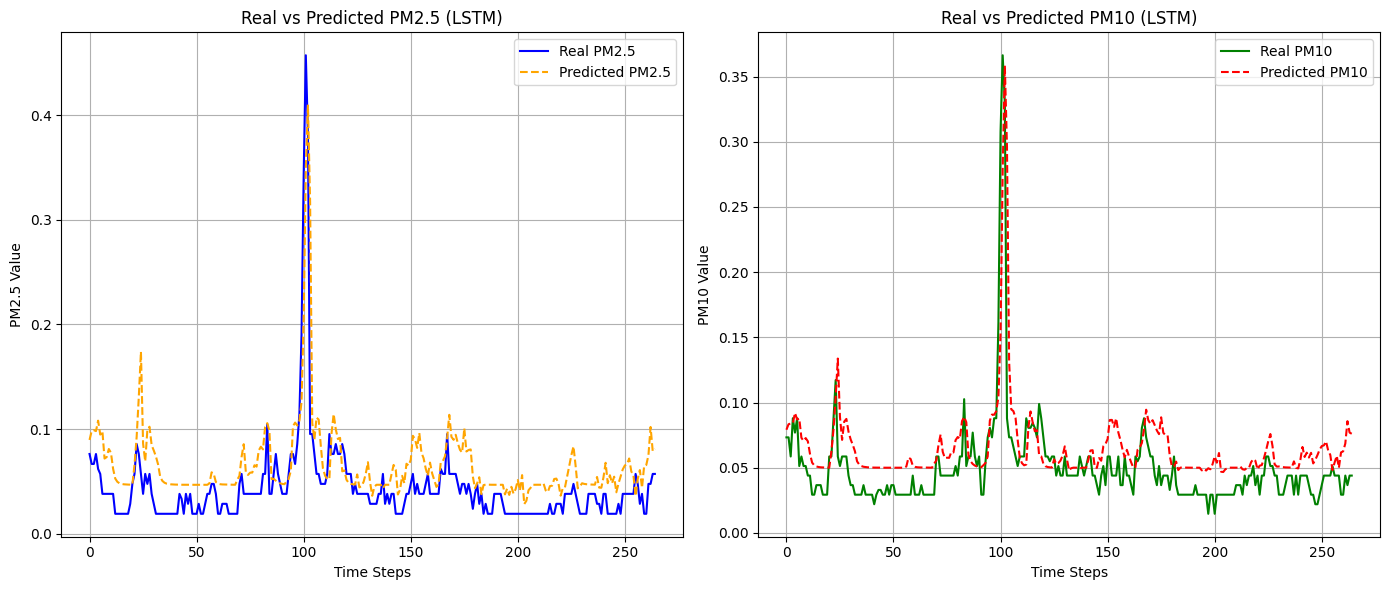

In [ ]:
# Predict on the test set
y_pred = lstm_model_2.predict(X_test)

# Extract the real and predicted values for pm25 and pm10
real_pm25 = y_test[:, 0]
real_pm10 = y_test[:, 1]
predicted_pm25 = y_pred[:, 0]
predicted_pm10 = y_pred[:, 1]

# Plotting the real and predicted values for pm25 and pm10 in two subplots
plt.figure(figsize=(14, 6))

# Subplot 1 for PM2.5
plt.subplot(1, 2, 1)
plt.plot(real_pm25, label='Real PM2.5', color='blue')
plt.plot(predicted_pm25, label='Predicted PM2.5', color='orange', linestyle='--')
plt.title('Real vs Predicted PM2.5 (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.grid(True)

# Subplot 2 for PM10
plt.subplot(1, 2, 2)
plt.plot(real_pm10, label='Real PM10', color='green')
plt.plot(predicted_pm10, label='Predicted PM10', color='red', linestyle='--')
plt.title('Real vs Predicted PM10 (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('PM10 Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### GRU

In [ ]:
# Define the GRU model
gru_model_2 = Sequential()
gru_model_2.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer with shape (24 timesteps, 7 features)
gru_model_2.add(GRU(32, activation='relu', return_sequences=True)) # First LSTM layer with 32 units, returning sequences to the next LSTM layer
gru_model_2.add(GRU(16, activation='relu', return_sequences=True)) # Second LSTM layer with 16 units, returning sequences to the next LSTM layer
gru_model_2.add(GRU(8, activation='relu')) # Third LSTM layer with 8 units, returning only the final output
gru_model_2.add(Dense(2)) # Output layer with 2 neurons to predict both pm25 and pm10

# Compile the model with Adam optimizer and learning rate of 0.001
gru_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_gru_model_2.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
gru_history_2 = gru_model_2.fit(X_train, y_train,
                                  epochs=100,
                                  validation_data=(X_valid, y_valid),
                                  callbacks=[early_stopping, checkpoint])

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0398 - val_loss: 7.9680e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0181 - val_loss: 6.7085e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0036 - val_loss: 7.3469e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0034 - val_loss: 6.0669e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023 - val_loss: 4.8808e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 4.2053e-04
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 3.7794e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - val_loss: 3.9725e-04
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 4.2602e-04
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 4.2271e-04
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 3.9086e-04
Epoch 1

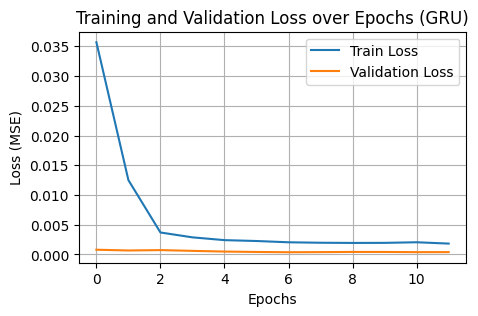

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(5, 3))
plt.plot(gru_history_2.history['loss'], label='Train Loss')
plt.plot(gru_history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = gru_model_2.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8798e-04 
Test Loss: 0.0010076325852423906


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


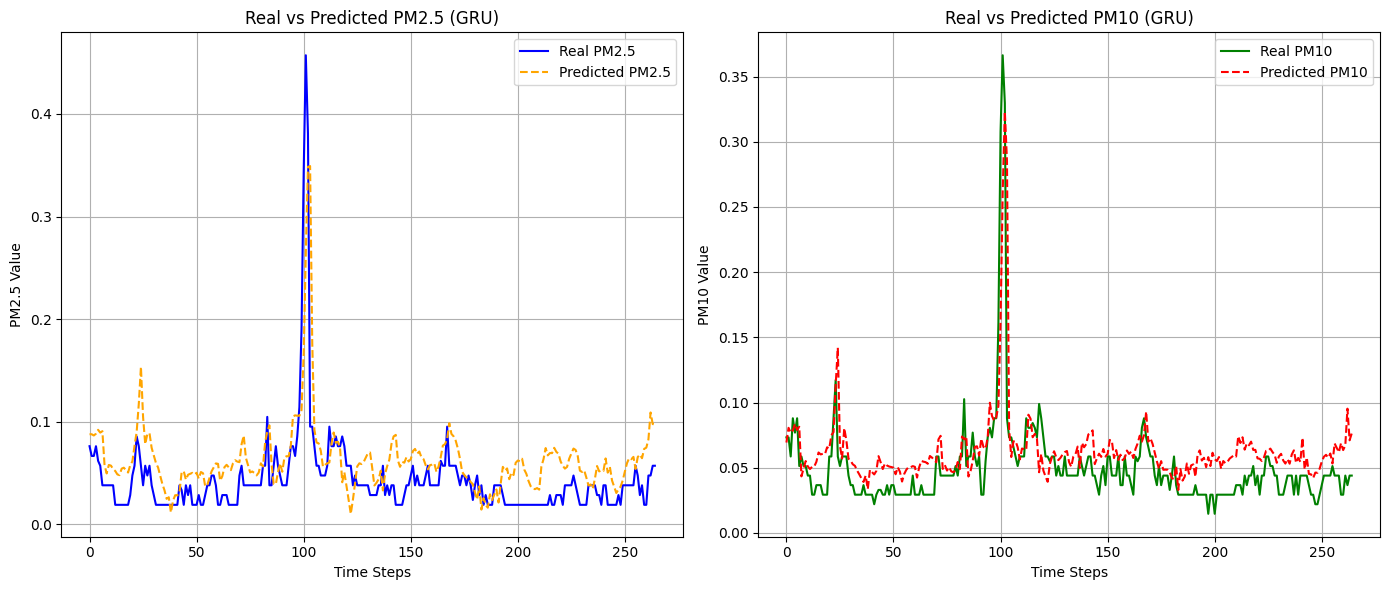

In [ ]:
# Predict on the test set
y_pred = gru_model_2.predict(X_test)

# Extract the real and predicted values for pm25 and pm10
num_samples = 300
real_pm25 = y_test[:num_samples, 0]
real_pm10 = y_test[:num_samples, 1]
predicted_pm25 = y_pred[:num_samples, 0]
predicted_pm10 = y_pred[:num_samples, 1]

# Plotting the real and predicted values for pm25 and pm10 in two subplots
plt.figure(figsize=(14, 6))

# Subplot 1 for PM2.5
plt.subplot(1, 2, 1)
plt.plot(real_pm25, label='Real PM2.5', color='blue')
plt.plot(predicted_pm25, label='Predicted PM2.5', color='orange', linestyle='--')
plt.title('Real vs Predicted PM2.5 (GRU)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.grid(True)

# Subplot 2 for PM10
plt.subplot(1, 2, 2)
plt.plot(real_pm10, label='Real PM10', color='green')
plt.plot(predicted_pm10, label='Predicted PM10', color='red', linestyle='--')
plt.title('Real vs Predicted PM10 (GRU)')
plt.xlabel('Time Steps')
plt.ylabel('PM10 Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In the second approach, where both environmental factors (e.g., temperature, humidity, wind) and historical PM2.5 and PM10 data were used to predict future air quality, the LSTM model outperformed the GRU model. The LSTM model had a lower test loss (0.0009264 vs. GRU's 0.0010076) and provided better alignment with the real PM2.5 and PM10 values, particularly around significant spikes and gradual fluctuations. While both models captured overall trends well, the GRU showed more deviation during complex changes, making the LSTM model more accurate and reliable in this scenario. Overall, incorporating additional environmental factors improved both models' performance, but LSTM had the edge in terms of prediction accuracy.

### Comparison of Best Results for Each Approach

When comparing the two approaches, the GRU model performed best when using only PM2.5 and PM10 historical data, achieving a lower test loss (0.0004169) than the LSTM model. However, when additional environmental factors like temperature, humidity, and wind were included, the LSTM model outperformed the GRU, handling complex fluctuations and spikes more accurately despite a slightly higher test loss (0.0009264). It's important to note that the dataset and the number of records available for training the model using the second approach (with environmental factors) were significantly smaller compared to the first approach, which may have influenced the performance and overall results.

Overall, GRU is better for simpler models using only historical air quality data, while LSTM is more effective when environmental factors are integrated for more comprehensive predictions.